# Helping Hotels in times of flexible bookings

Nearly 40 percent of on-the-books revenue is canceled before arrival, according to a study conducted by D-Edge Hospitality Solutions. The company analyzed the online distribution performance of more than 200 different channels for 680 properties in Europe between 2014 and 2018. Guests have become accustomed to free cancellation policies that have been made popular mainly by Booking.com. This customer behavior hinders accurate forecasting, eventually resulting in non-optimized occupancy.

The pandemic has changed the tourism industry and accelerated this development. 100% refund policies are meant to encourage customers to book hotels in an uncertain environment, however, this imposes cost to a hotel business, as rooms are reserved for a long time and then might be cancelled shortly in advance. This short time is often not enough to find a new, paying customer for the hotel room.

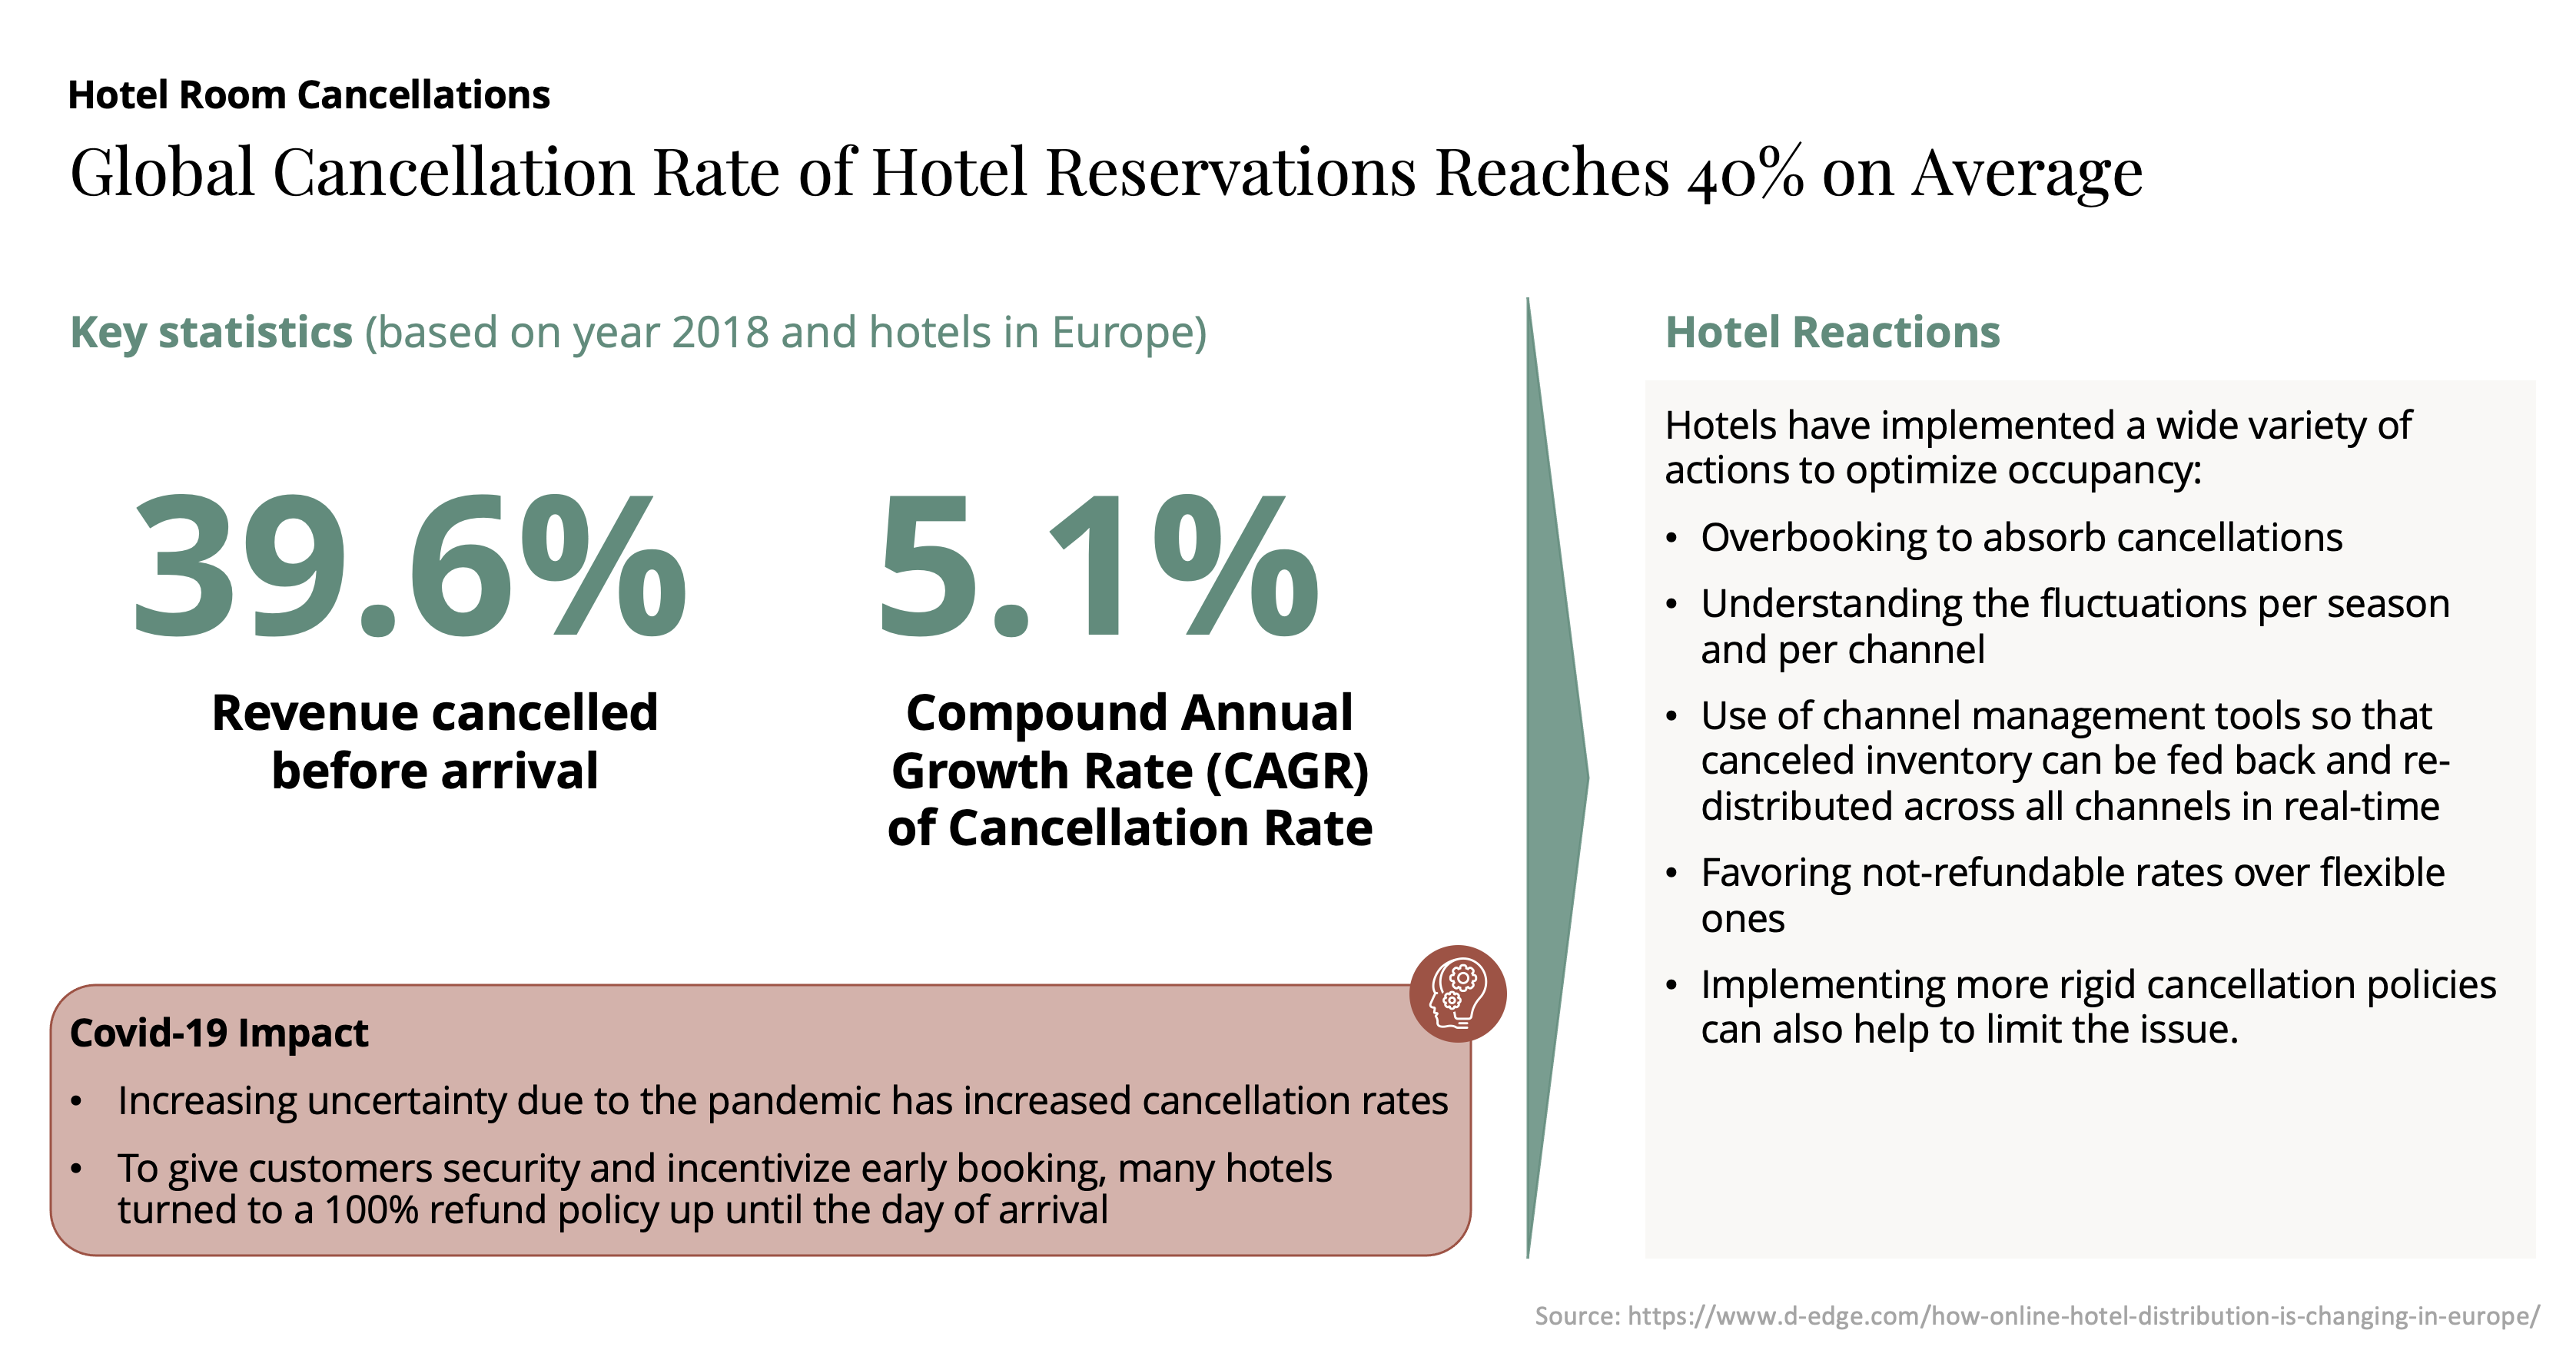

However, reducing the flexibility of bookings by dropping the user-friendly refund terms might put the hotel's competitiveness at risk. Therefore hotels might use a concept that is already prevailent in airlines: Overbooking the rooms they actually have and thereby absorbing the canellations (see abstraction below). By accepting more bookings than a hotel has rooms, it can make sure to be closer to full capacity utilization. However, this imposes the risk of not having rooms available and having to reject customers that have a reserved room. Therefore building a Machine Learning model that successfully predicts whether a customer is likely to cancel their booking is crucial in enabling the hotels to overbook the optimal number of rooms. That is the goal of this work.

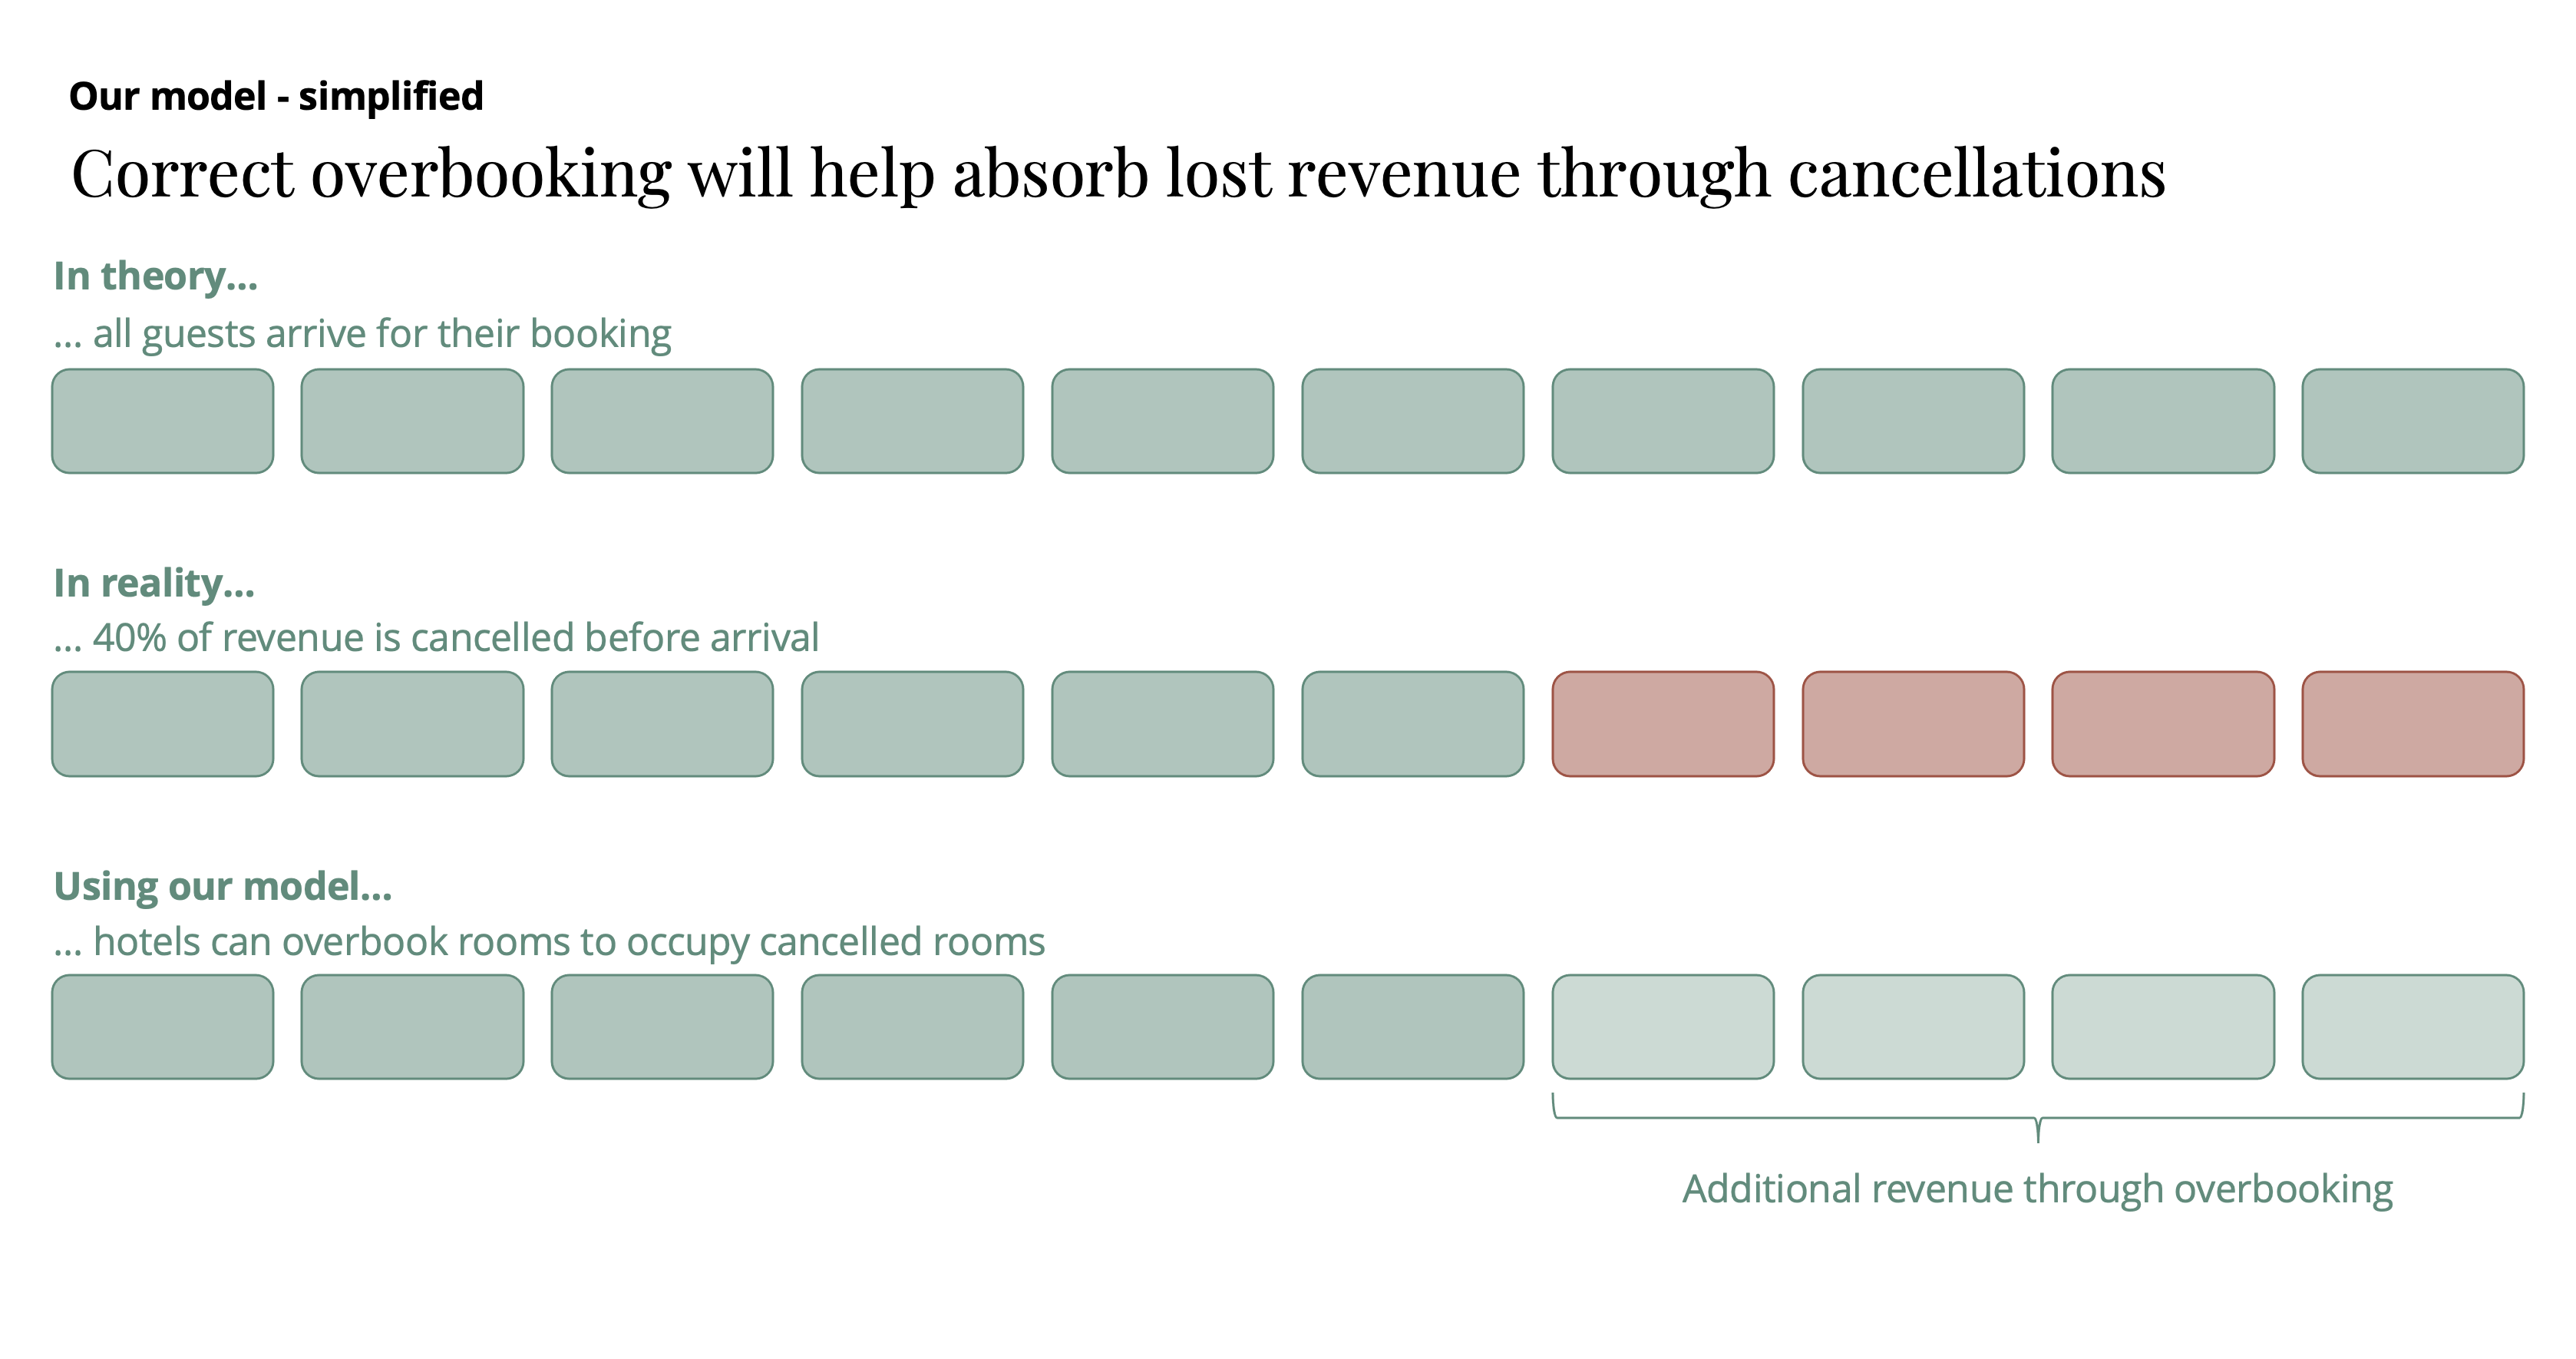

**After building our model, we successfully show that using our prediction algorithm, we can substantially improve the businesses revenue in the peak summer months. You can find the calculation [here](#businesscase).**

### <a id='performancemeasure'>Select a performance measure</a>


In order to select an appropriate performance measure for our model, we first have to discuss the outcomes of each case:

- *Cost of False Positives:*
<br>In this case, **we predict that a customer cancels the room, but he actually doesn't cancel** and shows up
<br>The hotel runs into the risk of having too many customers show up and therfore not being able to serve all of them with rooms. This can have bad consequences and negatively impact the reputation of the hotel. Avoiding this scenario should be of high priority, however revenue is not directly effected.
<br>
<br>
- *Cost of False Negatives:*
<br>In this case, **we predict that a customer does not cancel the room, but he actually cancels** and does not show up
<br>As the model does not predict a cancellation, the hotel does not overbook this room. Therefore, this scenario may lead to unoptimized occupancy, especiallly if cancellations are short-term and the hotel is not able to react appropriately.
<br>
<br>
- *Gain of True Positives:*
<br>In this case, **we correctly predict that a customer cancels the room** and does not show up
<br>Through the use of overbooking, Hotels will be able to fill this room. The use of our model will therefore lead to additional revenue through better occupancy and not loose the money due to loose refund policies.
<br>
<br>
- *Gain of True Negatives:*
<br>In this case, **we correctly predict that a customer does not cancel the room** and shows up
<br>The customer behaves in line with expactations and will occupy the room. The use of our model neither increases nor decreases revenue.
<br>
<br>

In the case of hotel booking, false positives and false negatives balance each other out. Let's look at an example:
<br>We falsely predict that two customers cancel the room (while they actually don't), and at the same time falsely predict that three customers do not cancel the room (while they actually do). In this case, the hotel has three empty rooms, but is able to fill them with the two customers that show up even though they were predicted as canceled. Consequently, all customers can be served with a room and - while there is still unserved capacity - the hotel does not suffer a loss of reputation.

Based on the previous assessment, **we choose the F1-score as our performance measure**. The F1-score elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall. It is calculated as follows:

$$
\
F1=\frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\
$$

In our use-case, the errors caused by FPs and FNs are equally undesirable. In fact, we care about having them as equal as possible. We want Recall and Precision to be as high as possible, without focussing more on one of the measures. Therefore, we choose F1 as the appropriate measure of performance.

This performance measure is also dependent on which type of hotel is using the model. As we don't have an indication for the hotel in our case, we assume it is a mid-range establishment - neither budget, nor luxurious. However, for luxurious hotels, reputation is everything. Therefore, we woud recommend using Recall as the performance measure, because false positives, i.e. the risk of too many bookings, are more costly. In the opposite case, for budget hotels, it is more important to have better capacity than loose reputation by overbooking, we therefore recommend using Precision as performance measure in these cases.

### Check the assumptions

The result of this model is a classification of whether a room will be cancelled or not. We can use this information to precisely overbook certain rooms on a daily basis. This is based on the assumptions that this is the information that hotels need to use overbooking as a way to optimize capacity. Instead of simply forecasting cancellation rates for upcoming weeks (as it is current practice), our model predicts cancellations on a much more granular level. This makes it possible to react more fexible and on a per-room basis.

## 0. Imports & Data Access

In [1]:
import matplotlib.pyplot as plt
import missingno
import pandas as pd
import seaborn as sns
import numpy as np
import os
from datetime import timedelta
from sklearn import set_config
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from typing import Dict, List, Union
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Binarizer, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
import tensorflow as tf
import tensorflow.keras as keras
import shap
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from tqdm import tqdm
import warnings
import shap
warnings.filterwarnings("ignore")

plt.style.use('seaborn')
seed = 42

In [2]:
exec_directory = os.getcwd()
main_directory = "Hotel-Booking-ML"
main_dir_path = exec_directory[:exec_directory.find(main_directory) + len(main_directory)]
raw_data_files_location = f"{main_dir_path}/data/raw"
df_all = pd.read_csv(f"{raw_data_files_location}/hotel_booking.csv")

## 1. Data Exploration

In [3]:
df_all.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


As a first step we'll drop the columns 'reservation_status' and 'reservation_status_date' as they include information on our label. The value 'canceled' in 'reservation_status' indicates the same as 'is_canceled', this obviously information we don't need and shouldn't feed into the model.

In [4]:
df_all.drop(columns = ['reservation_status', 'reservation_status_date' ], inplace = True)

<AxesSubplot:>

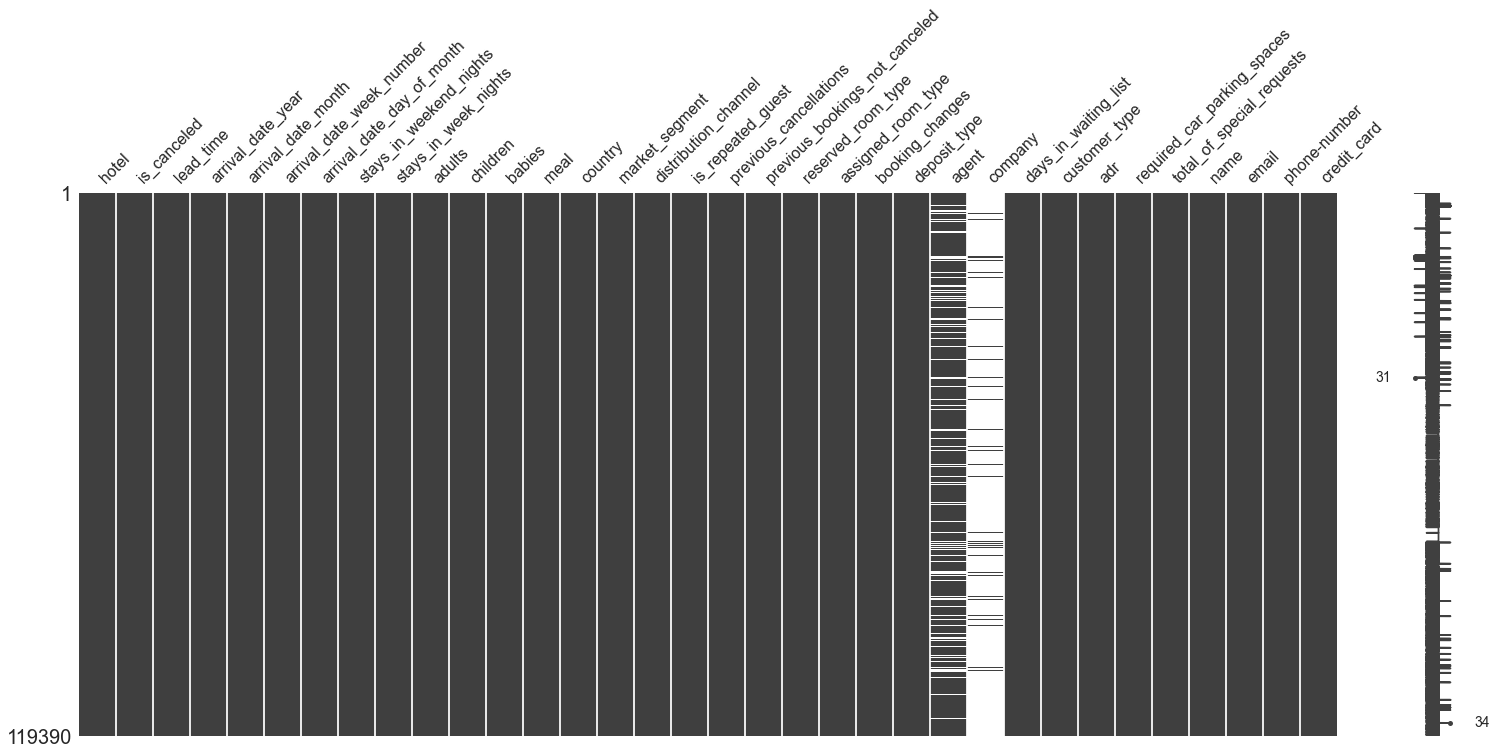

In [5]:
missingno.matrix(df_all)

#### Missing values

Luckily our dataset is mostly complete for all features apart from agent and company. According to the data dictionary of the dataset these columns represent IDs of the agents and companies (in case of business travel) that made the bookings. Therefore it is likely that missing values do represent an information: a NA in 'company' indicates that the booking was not a business travel and a NA in 'agent' indicates that no agent was used for the booking, meaning that it was a direct booking.

Therefore we'll use OneHot encoding later on, to understand if there is a correlation between company, agent and our labels. 

#### Data transformation and aggregation. 

Before starting with the EDA, we try combine attributes to generate new information or aggregate redundant information.

We'll transform arrival and booking date to datetime format and transform the type of children in order to facilitate subsequent code operations. <br> We'll also aggregate data by calculating the number of total nights and retrieving the total number of guests. The aim of this is to reduce the number of features by aggregating redundant / similar information. <br> Furthermore, we'll add a column that represents the average daily revenue per guest instead of the total ADR of all guests of a booking.

In [6]:
df_all.dropna(subset=['children'], inplace=True)
df_all['children'] = df_all['children'].astype(int)
df_all = df_all.astype({"country": str})

In [7]:
# Getting arrival and booking dates right
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
                         'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_all['arrival_date_month'] = df_all['arrival_date_month'].apply(lambda m: month_mapping[m])
df_all['arrival_date'] = pd.to_datetime(dict(year = df_all.arrival_date_year, 
                                         month = df_all.arrival_date_month, 
                                         day = df_all.arrival_date_day_of_month))
df_all = df_all.sort_values('arrival_date')

df_all['booking_date'] = df_all.apply(lambda r: r['arrival_date'] - timedelta(days=r['lead_time']), axis=1)
df_all['booking_date_day_of_week'] = df_all['booking_date'].dt.weekday

# Number of Guests
df_all['guests'] = df_all['adults'] + df_all['children'] + df_all['babies']

# Length of stay
df_all['stay_total_nights'] = df_all['stays_in_weekend_nights'] + df_all['stays_in_week_nights']

# Is Family
df_all['is_family'] = np.where((df_all['children'] >= 1) | (df_all['babies'] >= 1), 1, 0)

# Assigned room type changed from booked room type
df_all['room_changed'] = np.where(df_all['reserved_room_type'] == df_all['assigned_room_type'], 0, 1)

# Average daily revenue per guest

df_all['adr_per_guest'] = df_all['adr'] / df_all['guests'].replace({0: df_all['guests'].median()})

As a second step, we split the data in a train and a test set before working on the data, because we don't want to influence our training and analysis by any information from the test set. We are using a 22 month period from 1st of July 2015 till 1st of May 2017 for training. Later, we will test our model's performance on a 4 month period from May to August 2017. This period is also a high demand period for hotels in which well-executed overbooking can be especially benefitial.

In [8]:
import datetime
split_date = datetime.datetime(2017, 5, 1)
df = df_all[df_all['arrival_date'] < split_date]
df_test = df_all[df_all['arrival_date'] >= split_date]
print(df.shape)
print(df_test.shape)
print(f"Train: {round(df.shape[0] / df_all.shape[0] * 100, 1)}% | Test: {round(df_test.shape[0] / df_all.shape[0] * 100, 1)}%")

(97188, 42)
(22198, 42)
Train: 81.4% | Test: 18.6%


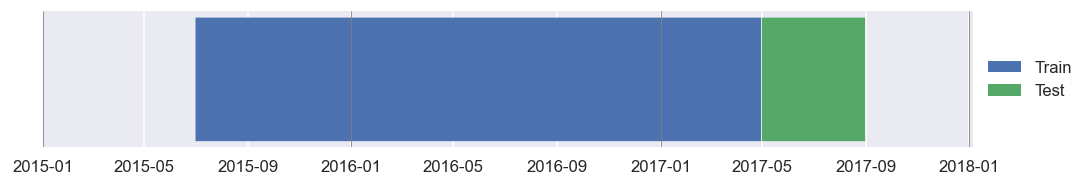

In [9]:
plt.figure(figsize=(10,1.5), dpi=120)
plt.fill_between(df.arrival_date, np.ones(df.shape[0]), label="Train")
plt.fill_between(df_test.arrival_date, np.ones(df_test.shape[0]), label="Test")
plt.xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2018, 1, 1))
for ny in ['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01']:
    plt.axvline(pd.to_datetime(ny), lw=0.5, color='grey')
plt.gca().get_yaxis().set_visible(False)
plt.xlim(datetime.datetime(2015, 1, 1), datetime.datetime(2018, 1, 5))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## 2. Exploratory Data Analysis
We firstly split the EDA for categorical and numerical features, as we'll perform different analysis methods for each data type.

There are two exceptions here:
- We'll see binary variables (with 0 and 1) as a numerical feature, as it can be analyzed with the methods we use for the 'true' numerical features.
- The 'hotel' feature describes whether the data is for a 'City Hotel' or a 'Resort Hotel', it will be analyzed in numerical features as well. This is because we want to identify if it is worth to split the data we have according to the hotel and build separate models for each of the hotels.

In [11]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,phone-number,credit_card,arrival_date,booking_date,booking_date_day_of_week,guests,stay_total_nights,is_family,room_changed,adr_per_guest
0,Resort Hotel,0,342,2015,7,27,1,0,0,2,...,669-792-1661,************4322,2015-07-01,2014-07-24,3,2,0,0,0,0.0
1,Resort Hotel,0,737,2015,7,27,1,0,0,2,...,858-637-6955,************9157,2015-07-01,2013-06-24,0,2,0,0,0,0.0
2,Resort Hotel,0,7,2015,7,27,1,0,1,1,...,652-885-2745,************3734,2015-07-01,2015-06-24,2,1,1,0,1,75.0
3,Resort Hotel,0,13,2015,7,27,1,0,1,1,...,364-656-8427,************5677,2015-07-01,2015-06-18,3,1,1,0,0,75.0
4,Resort Hotel,0,14,2015,7,27,1,0,2,2,...,713-226-5883,************5498,2015-07-01,2015-06-17,2,2,2,0,0,49.0


In [12]:
categorical_features = [ 'meal', 'country', 'market_segment', 'distribution_channel', 
                         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 
                         'customer_type']

df_num = df.drop(columns = categorical_features)

categorical_features.append('is_canceled')
df_cat = df[categorical_features]

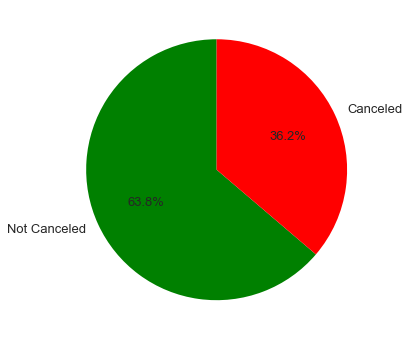

In [13]:
#display canceled and not canceled 
num_can = df['is_canceled'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(num_can, labels=['Not Canceled', 'Canceled'], 
        autopct='%.1f%%', 
        startangle=90, 
        colors = ['green', 'red'],
        textprops={'fontsize': 13})
plt.show()

The share of cancellations (36.2%) is quite similar to the average share of canceled revenue for Europe in 2018 (39.6%), as found in the study mentioned in 1.

### 2.1 Numerical features
#### 2.1.1 Correlations

First we'll take a look at collinearity in the data set, by pairplotting relevant features and calculating their correlations.

Please note that we are only using aggregated features here and not the features we calculated these aggregated ones on. For example, it wouldn't make sense to check for collinearity in guests with adults, children or babies as these variables are obviously correlated and won't be used side by side in the model. 

<AxesSubplot:>

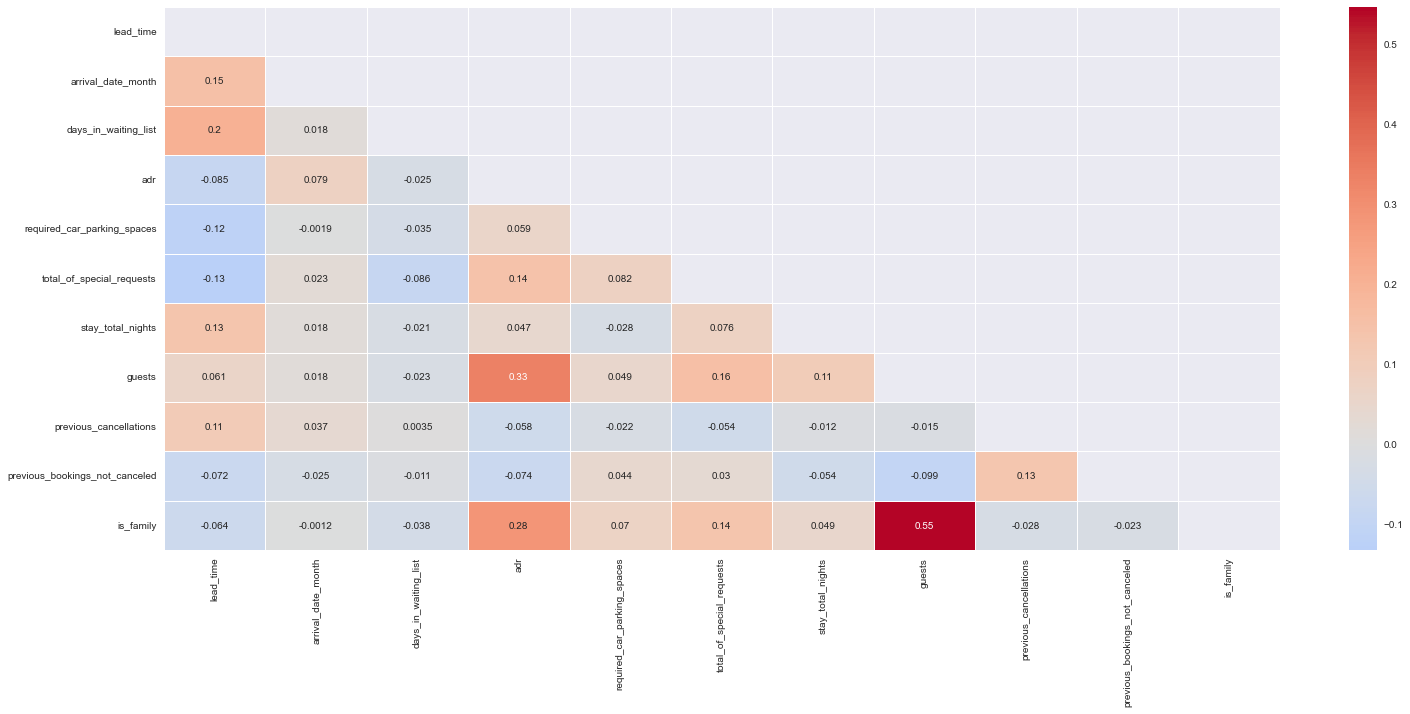

In [14]:
plt.figure(figsize=(25,10))
corr = df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr','required_car_parking_spaces', 'total_of_special_requests',
               'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

#Plot Correlation Heatmap
sns.heatmap(corr,
            annot = True,
            linecolor = 'white',
            mask = mask,
            linewidths = 1,
            center = 0,
            cmap = 'coolwarm') 

In [15]:
df_corr = pd.DataFrame(df_num[['lead_time', 'arrival_date_month','days_in_waiting_list', 'adr', 
                          'required_car_parking_spaces', 'total_of_special_requests',
                          'stay_total_nights', 'guests','previous_cancellations','previous_bookings_not_canceled','is_family']].corr().unstack()).rename({0: 'correlation'}, axis=1)
df_corr[df_corr['correlation'] != 1].sort_values(by='correlation')

,,correlation
lead_time,total_of_special_requests,-0.132239
total_of_special_requests,lead_time,-0.132239
lead_time,required_car_parking_spaces,-0.118180
required_car_parking_spaces,lead_time,-0.118180
previous_bookings_not_canceled,guests,-0.098961
...,...,...
is_family,adr,0.281356
adr,guests,0.332327
guests,adr,0.332327
is_family,guests,0.546240


The highest correlation among our features is the correlation of ADR (revenue per day) with the number of guests, this follows the logic that with the more people you stay in a hotel, the more you'll spend. When building the model we'll take a closer look if this becomes a problem. For the other features the correlations are really small and therefore no worry.  

Now, lets get the correlations of the **label** with the features, separately for the resort and city hotel to find out if they differ substiantially. This will be interesting when deciding whether to build separate models or not. 

In [16]:
correlations_all = df_num.corr()['is_canceled'].sort_values(ascending=False)
correlations_city = df_num[df_num['hotel'] == 'City Hotel'].corr()['is_canceled']
correlations_resort = df_num[df_num['hotel'] == 'Resort Hotel'].corr()['is_canceled']
correlations_df = correlations_all.to_frame().rename({'is_canceled': "All"}, axis=1)
correlations_df = correlations_df.join(correlations_city).rename({'is_canceled': "City"}, axis=1)
correlations_df = correlations_df.join(correlations_resort).rename({'is_canceled': "Resort"}, axis=1)
correlations_df

,All,City,Resort
is_canceled,1.000000,1.000000,1.000000
lead_time,0.322420,0.350271,0.223346
previous_cancellations,0.126483,0.197640,0.131513
adults,0.062478,0.056767,0.081217
days_in_waiting_list,0.061571,0.067168,-0.037844
guests,0.046230,0.027032,0.091215
booking_date_day_of_week,0.041744,0.036477,0.035346
adr,0.035537,-0.023667,0.073375
stays_in_week_nights,0.018612,0.045250,0.068652
arrival_date_month,0.017985,0.013205,0.025082


This already gives a good indication, but let's plot the data to make the difference easier to understand.

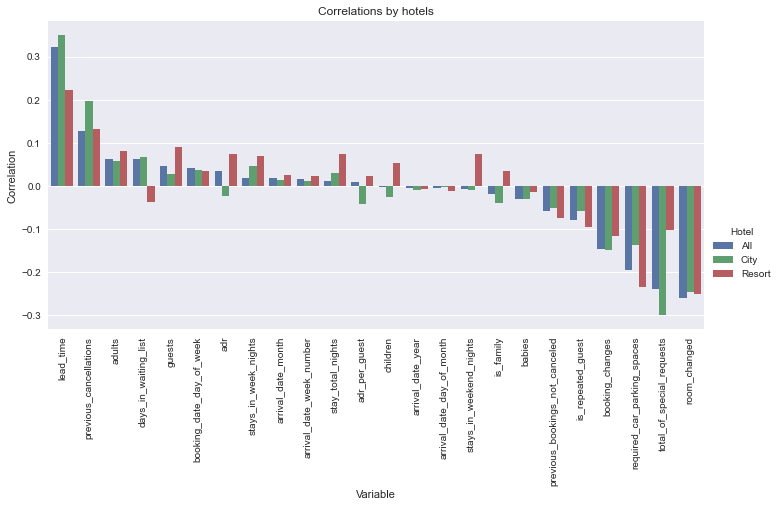

In [17]:
correlations_plot_df = pd.melt(correlations_df.drop('is_canceled'), ignore_index=False, var_name="Hotel", value_name="Correlation")
correlations_plot_df['Variable'] = correlations_plot_df.index
sns.catplot(data=correlations_plot_df, kind='bar', x='Variable', y='Correlation', hue='Hotel', aspect=2)
plt.xticks(rotation=90)
plt.title('Correlations by hotels')
plt.show()

This bar-chart shows that lead_time, previous_canellations, total_of_special_requests, required_car_parking_space and booking_changes have a correlation that is higher than 0.1 (in absolute terms). These are important candidates for our ML model later on. Additionally, the chart shows that for some features the correlation heavily depends on the kind of hotel we are looking at: For example, the number of total special requests is highly correlated with the cancellations at the city hotel, but not so much at the resort hotel.

We can see that the lead time is highly correlated with the label. It's interesting to see patterns for the length of the lead time and the related cancellations, for each hotel.

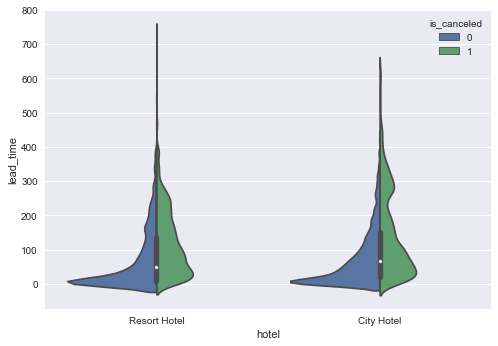

In [18]:
sns.violinplot(data=df, x='hotel', y='lead_time', hue='is_canceled', split=True)
plt.show()

For the city hotel, the vast majority of bookings with lead time > 200 days gets canceled, while for the resort hotel this tendency also exists, but is not equally strong. We can also see that most bookings are made only days before arrival. These are then less likely to be cancelled.

The column *'booking_changes'* describes changes that cumulate over time. This count can change until the day of arrival. For our model, this will not be usable since when making a prediction if a customer cancels, we don't know how many changes they will make to the booking in the future. Thus, *'booking_changes'* will be disregarded for the model.

Some continuous numeric variables can also be transformed into binary form by simply checking whether they are > 0, which could benefit the model's performance. In order to find out which option should be picked, we will look at the correlations with the target variable is_canceled. Let's first look at *total_of_special_requests* vs. *any_requests*.

In [19]:
df_corrcheck = df
df_corrcheck['any_requests'] = df_corrcheck.total_of_special_requests.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_requests', 'total_of_special_requests']].corr()

,is_canceled,any_requests,total_of_special_requests
is_canceled,1.000000,-0.274610,-0.238382
any_requests,-0.274610,1.000000,0.870224
total_of_special_requests,-0.238382,0.870224,1.000000


As the binary variable any_requests is more correlated with is_canceled, we will choose this option later on. Now let's inspect previous_canellations.

In [20]:
df_corrcheck['any_cancelations'] = df_corrcheck.previous_cancellations.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_cancelations', 'previous_cancellations']].corr()

,is_canceled,any_cancelations,previous_cancellations
is_canceled,1.000000,0.313100,0.126483
any_cancelations,0.313100,1.000000,0.424056
previous_cancellations,0.126483,0.424056,1.000000


This correlation is significantly higher in binary form. We will therefore use it in our model. Next up: required_car_parking_spaces.

In [21]:
df_corrcheck['any_parking'] = df_corrcheck.required_car_parking_spaces.apply(lambda x: 1 if x > 0 else 0)
df_corrcheck[['is_canceled', 'any_parking', 'required_car_parking_spaces']].corr()

,is_canceled,any_parking,required_car_parking_spaces
is_canceled,1.000000,-0.197992,-0.195897
any_parking,-0.197992,1.000000,0.989420
required_car_parking_spaces,-0.195897,0.989420,1.000000


There is only little difference between the binary and the numeric column. We will go for the binary variable to keep the model simpler.

#### 2.1.2 Frequency Distributions

Frequency distribution of time related Data


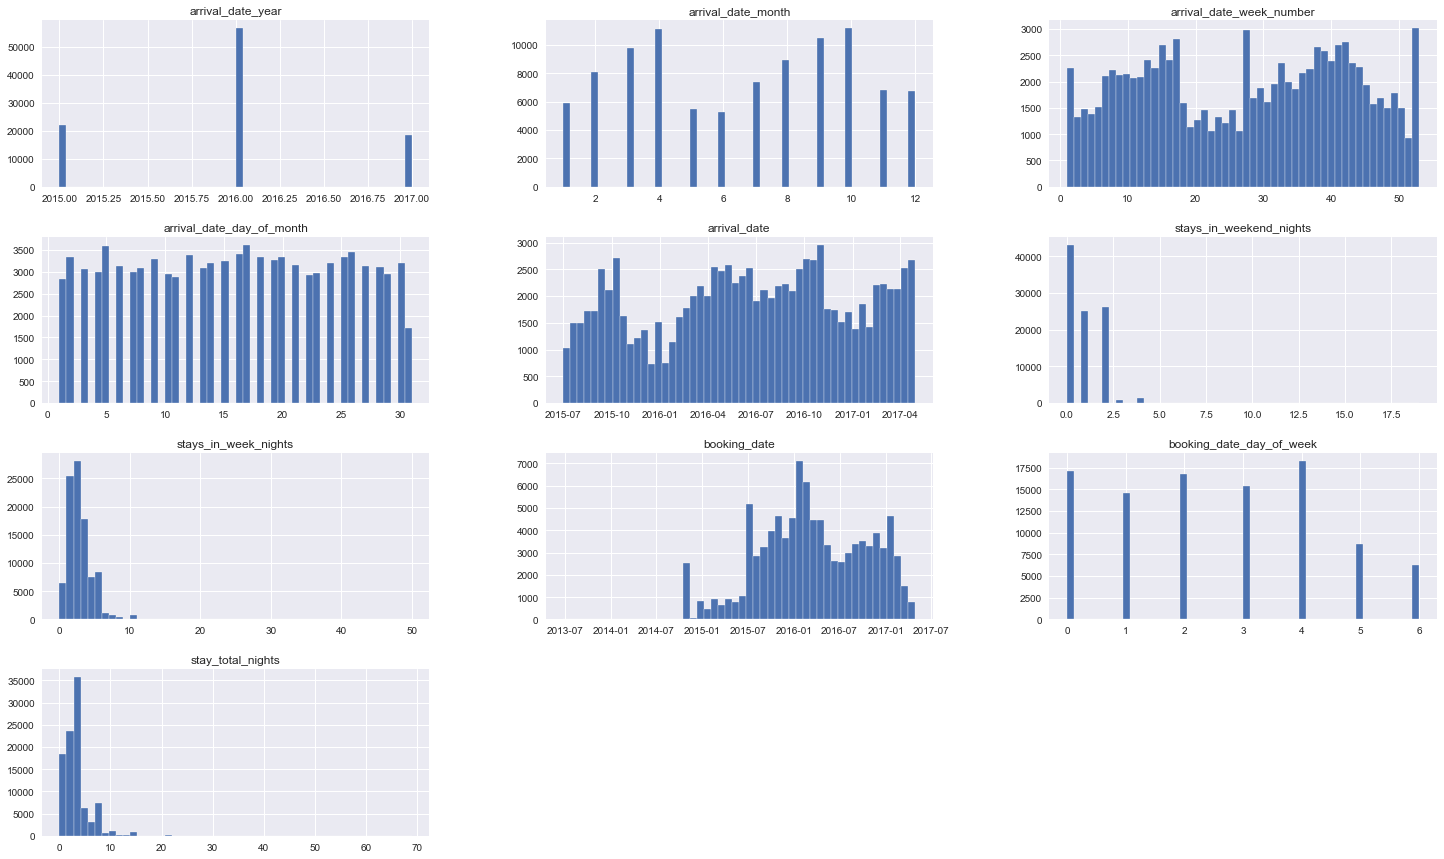

In [28]:
#time related frequency distribution 

df_num_time = df_num[['arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month' ,'arrival_date', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'booking_date',
       'booking_date_day_of_week','stay_total_nights']]

df_num_time.hist(bins=50, figsize=(25,15))
print('Frequency distribution of time related Data')
plt.show()

Frequency distribution of guest characteristics


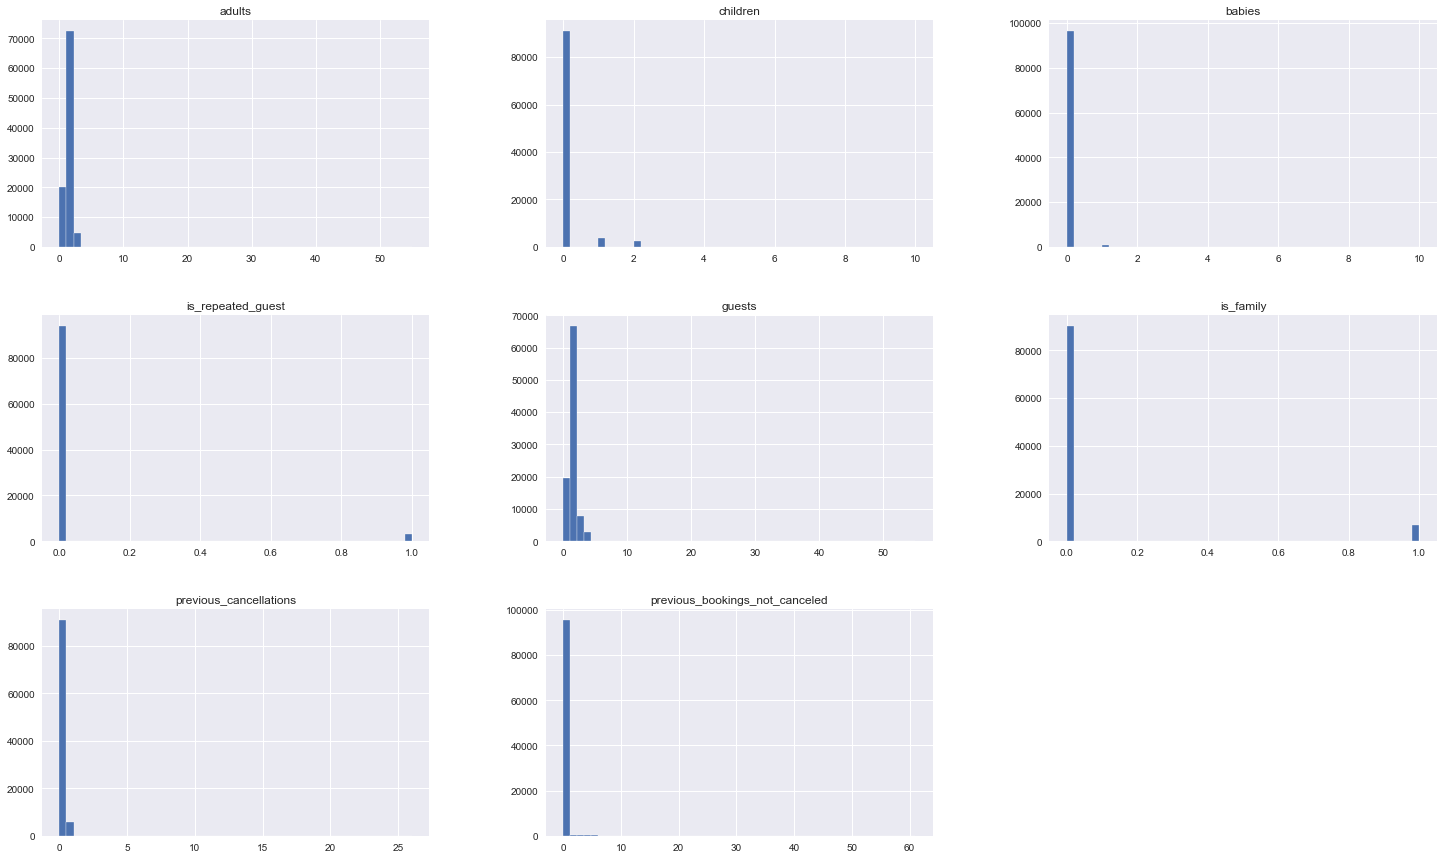

In [29]:
#guest characteristics frequency distribution

df_num_guest_characteristics = df_num[['adults', 'children', 'babies',
       'is_repeated_guest','guests', 'is_family', 'previous_cancellations',
       'previous_bookings_not_canceled']]

df_num_guest_characteristics.hist(bins=50, figsize=(25,15))
print('Frequency distribution of guest characteristics')
plt.show()

Frequency distribution of booking characteristics


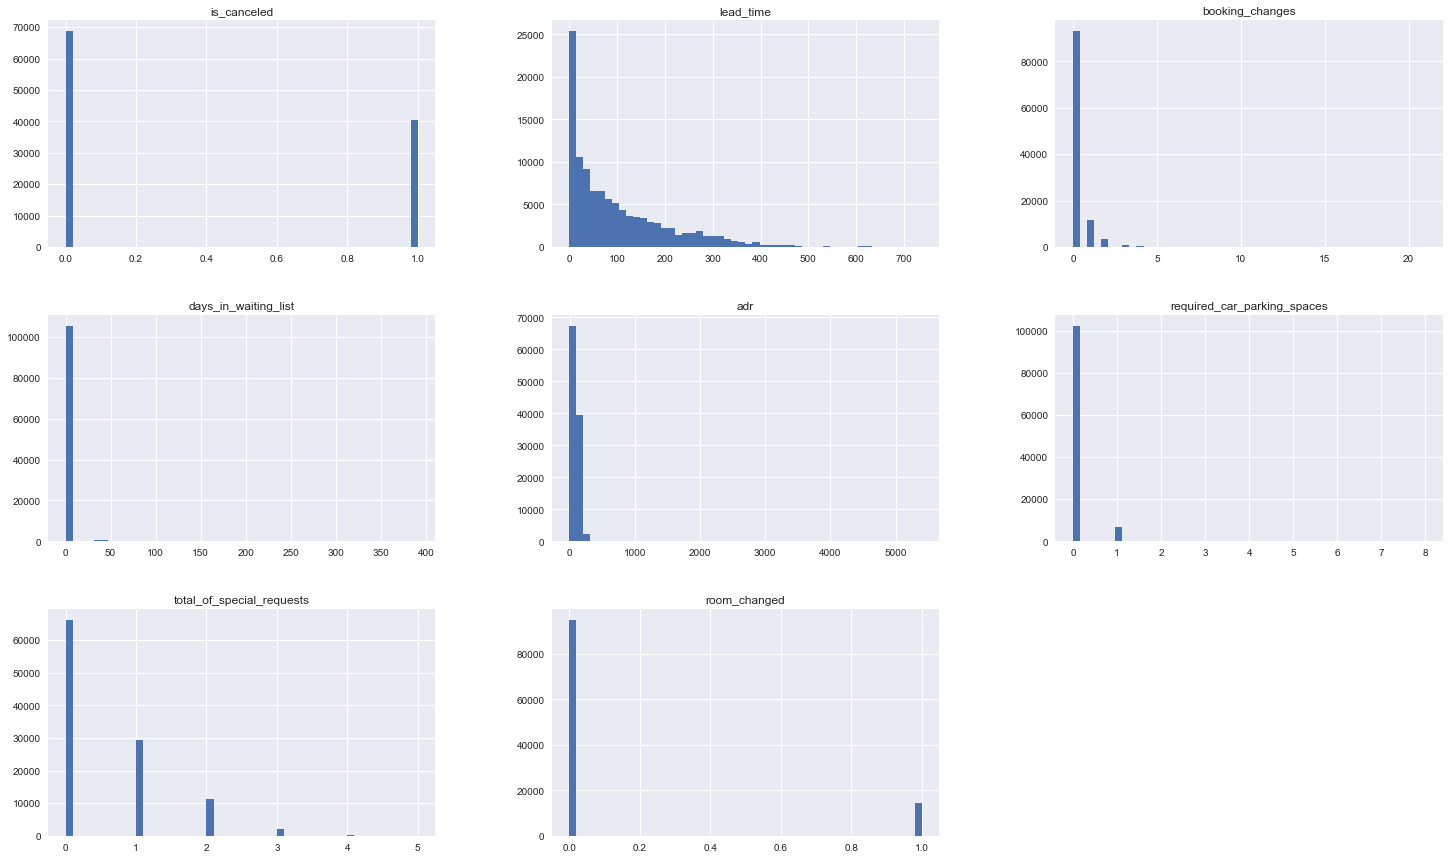

In [55]:
#booking characteristics frequency distribution

df_num_booking_characteristics = df_num[['hotel', 'is_canceled', 'lead_time', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests','room_changed']]

df_num_booking_characteristics.hist(bins=50, figsize=(25,15))
print('Frequency distribution of booking characteristics')
plt.show()

Now, we look at the characteristics of when customers usually order:

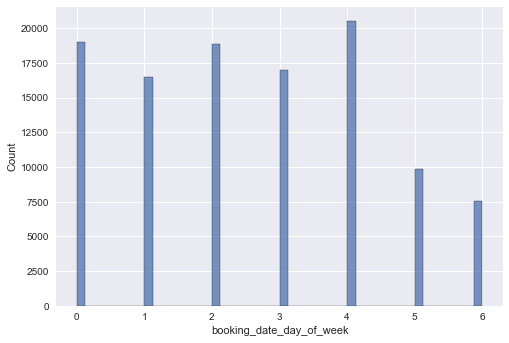

In [21]:
sns.histplot(df['booking_date_day_of_week'])
plt.show(sns)

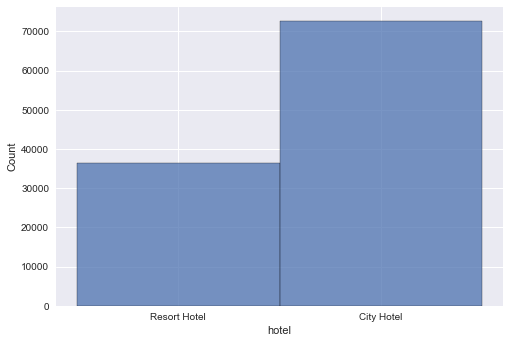

In [32]:
sns.histplot(df['hotel'])
plt.show(sns)

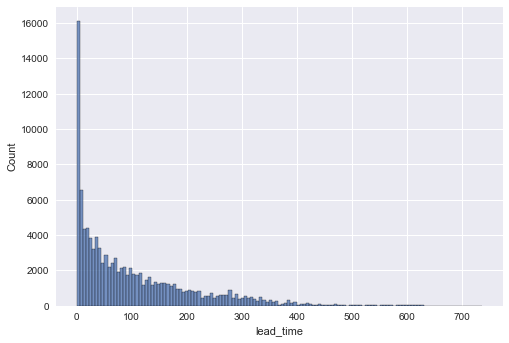

In [23]:
sns.histplot(df['lead_time'])
plt.show(sns)

### 2.2 Categorical variables

#### 2.2.1 Understanding the categories

Here we'll use df_cat, with all categorical features we have identified perviously. 

In [22]:
df_cat.columns

Index(['meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent',
       'company', 'customer_type', 'is_canceled'],
      dtype='object')

'Company' and 'agent' are columns with ids. Let's look at the values in the other ("true") categorical variables to get a feeling for what they are. 

In [23]:
df_cat[['meal']].value_counts(normalize = True)

meal     
BB           0.783440
HB           0.118698
SC           0.078940
Undefined    0.011421
FB           0.007501
dtype: float64

In [24]:
df_cat[['country']].value_counts(normalize = True).head(10)

country
PRT        0.432553
GBR        0.092944
FRA        0.087346
ESP        0.074238
DEU        0.057085
ITA        0.032401
IRL        0.025435
BRA        0.017780
BEL        0.017595
NLD        0.017564
dtype: float64

In [25]:
df_cat[['market_segment']].value_counts(normalize = True)

market_segment
Online TA         0.446516
Offline TA/TO     0.212639
Groups            0.179940
Direct            0.104262
Corporate         0.048380
Complementary     0.006575
Aviation          0.001687
dtype: float64

In [26]:
df_cat[['distribution_channel']].value_counts(normalize = True)

distribution_channel
TA/TO                   0.813495
Direct                  0.123482
Corporate               0.061427
GDS                     0.001585
Undefined               0.000010
dtype: float64

In [27]:
df_cat[['reserved_room_type']].value_counts(normalize = True)

reserved_room_type
A                     0.737756
D                     0.150533
E                     0.051375
F                     0.023182
G                     0.016185
B                     0.010361
C                     0.005731
H                     0.004713
P                     0.000103
L                     0.000062
dtype: float64

In [28]:
df_cat[['assigned_room_type']].value_counts(normalize = True)

assigned_room_type
A                     0.623606
D                     0.210911
E                     0.063773
F                     0.030930
B                     0.020280
G                     0.020229
C                     0.018809
H                     0.005659
I                     0.003159
K                     0.002531
P                     0.000103
L                     0.000010
dtype: float64

In [29]:
df_cat[['deposit_type']].value_counts(normalize = True)

deposit_type
No Deposit      0.869315
Non Refund      0.129234
Refundable      0.001451
dtype: float64

In [30]:
df_cat[['customer_type']].value_counts(normalize = True)

customer_type  
Transient          0.728506
Transient-Party    0.229884
Contract           0.036826
Group              0.004785
dtype: float64

Especially, the deposit type seems likely to have a high explanatory power. If you have made no deposit you are much more likely to cancel a booking than when you made a non-refundable deposit, right?

#### 2.2.2 Correlations of categorical variables with cancellations

Let's OneHot Encode the categories and IDs (for agent and company) in the next step and get their correlations with the cancellations. 

In [31]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(sparse = False)
df_cat = df_cat.sort_index().reset_index(drop = True)
df_cat_trans = pd.DataFrame(data = onehot.fit_transform(df_cat.drop(columns = 'is_canceled')),
                                columns = onehot.get_feature_names_out())

In [32]:
df_cat_trans = pd.concat([df_cat.is_canceled, df_cat_trans], axis = 1 )

Now we'll use this transformed dataframe of our categorical variables and find out how correlated they are with 'is_canceled'.

Watch out, the next cell takes quite a while to compute. 

In [33]:
df_cat_corr = df_cat_trans.corr()
df_cat_corr = df_cat_corr['is_canceled']

In [34]:
df_cat_corr.sort_values()

deposit_type_No Deposit       -0.500463
market_segment_Direct         -0.154167
distribution_channel_Direct   -0.151399
assigned_room_type_D          -0.141988
country_FRA                   -0.128978
                                 ...   
assigned_room_type_A           0.222777
market_segment_Groups          0.233520
country_PRT                    0.354154
deposit_type_Non Refund        0.505148
is_canceled                    1.000000
Name: is_canceled, Length: 864, dtype: float64

This is gives a dataframe of 864 correlations with the label. Very likely, most of them will have a very low correlation with the label. Therefore, let's only look at the ones with a correlation of more than 0.05 (positive or negative).

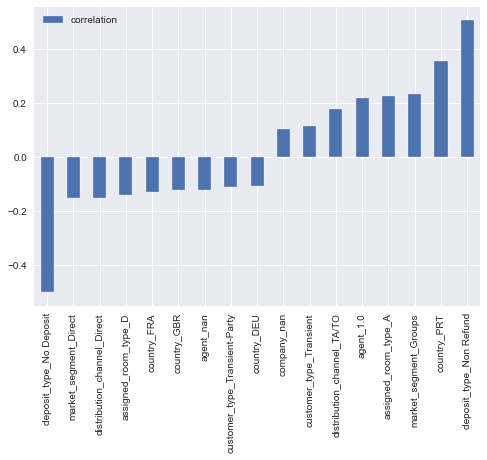

In [35]:
df_cat_corr_red = pd.DataFrame(df_cat_corr).rename({'is_canceled' : 'correlation'}, axis = 1)
df_cat_corr_red = df_cat_corr_red[(df_cat_corr_red['correlation'] >= 0.1 ) | (df_cat_corr_red['correlation'] <= -0.1) ]
df_cat_corr_red.sort_values(by = 'correlation')[:-1].plot(kind = 'bar')
plt.show()

This gives us a good indication, that especially x2 (= 'deposit_type') is likely to have a high explanatory power. But also x1 = ('Country') equalling to Portugal, x2 (= 'market_segment') equalling to Groups can be important when building the model.

But wait... the correlation indicates that customers are more likely to cancel a booking when they get no refund and less likely to cancel when they made no deposit (they don't need to pay anything in case they cancel). Logically, this should be the other way around. It seems to us, like this is a data introduction error. In order to be on the safe side, **we will exclude the attribute *deposit_type* from the model** - unfortunately, because they seem to have high explanatory value.

### 2.3 Time Series Analysis
In this section we are looking for underlying seasonality in the given cancellations and bookings.

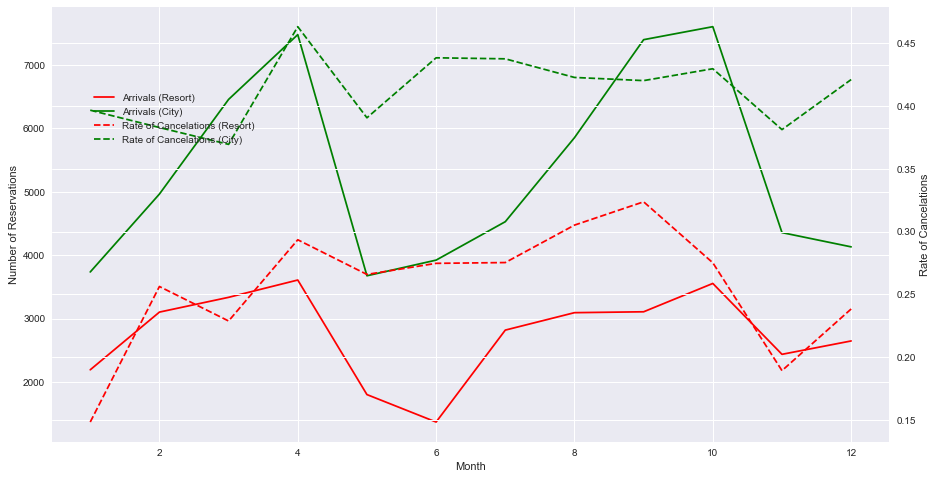

In [36]:
df_resort = df[df["hotel"] == "Resort Hotel"]
df_city = df[df["hotel"] == "City Hotel"]

#Get data for Resort Hotel
df_timeseries_r = pd.DataFrame(df_resort.groupby("arrival_date_month").size())
df_timeseries_r["Cancelations"] = df_resort.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_r.columns = ['Arrivals', 'Cancelations']
df_timeseries_r["Cancelation_Share"] = df_timeseries_r["Cancelations"]/df_timeseries_r["Arrivals"]

#Get data for City Hotel
df_timeseries_c = pd.DataFrame(df_city.groupby("arrival_date_month").size())
df_timeseries_c["Cancelations"] = df_city.groupby("arrival_date_month")["is_canceled"].sum()
df_timeseries_c.columns = ['Arrivals', 'Cancelations']
df_timeseries_c["Cancelation_Share"] = df_timeseries_c["Cancelations"]/df_timeseries_c["Arrivals"]

#Plot linechart
fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Reservations")
ax1.plot(
    df_timeseries_r["Arrivals"],
    color="red",
    label="Arrivals (Resort)"
)

ax1.plot(
    df_timeseries_c["Arrivals"],
    color="green",
    label="Arrivals (City)"
)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel("Rate of Cancelations")
ax2.plot(
    df_timeseries_r["Cancelation_Share"],
    color="red",
    linestyle="dashed",
    label="Rate of Cancelations (Resort)",
)

ax2.plot(
    df_timeseries_c["Cancelation_Share"],
    color="green",
    linestyle="dashed",
    label="Rate of Cancelations (City)",
)

fig.legend(loc = 2, borderaxespad=9)

Based on this plot, we can draw several conclusions:

- Bookings and cancellation-rate differ greatly between Resort and City Hotels. With City Hotels experiencing more bookings but also more cancellations.
- Cancellation rate follows the same patten as the number of bookings.
- Bookings and cancellations follow a seasonal pattern.

## 3. Preliminary Model Selection
Before going deeper into feature selection, we want to understand which model is the most promising for our task. For this model, more sophisticated feature selection will be conducted. We will test 5 different models that cover the spectrum of prevalent classification models, including a simple regression model, recent machine learning models and a neural network. Namely, these models are:
1. Logistic Regression with L1 penalty
2. Logistic Regression with L2 penalty
3. Random Forest Classifier
4. XGBoost Classifier
5. Linear SVM
6. Polynomial SVM
7. Radial Basis Function (RBF) SVM
8. Artificial Neural Network

### 3.1 Feature Selection Pipeline
Before testing the models, we need to build a pipeline in which all features get transformed into a format the models can best work with. Numerical features are standard scaled. For the categorical features, dimensions with less than 5% occurrences are aggregated in a 'other' category. Subsequently, categories are one-hot-encoded. The features *booking_changes* and *deposit_type* are excluded from the feature selection due to their inadequateness depicted in *2*.

In [10]:
num_features = ['lead_time', 'adr', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_week_nights', 'stays_in_weekend_nights', 'stay_total_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'days_in_waiting_list', 'total_of_special_requests', 'room_changed', 'adr_per_guest']

cat_features = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type']

class replace_other(TransformerMixin):
    """Replaces every value that accounts for less than 5% of the count of all unique
    values in the column with 'Other'"""

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, df):
        for col in df.columns:
            counts = df[col].value_counts(normalize=True)
            irrelevant = counts[counts < 0.05].index.tolist()
            df[col] = df[col].apply(lambda v: 'Other' if v in irrelevant else v)
        return df

    def get_feature_names_out(self, col_names):
        return col_names

cat_selection_pipeline = Pipeline(steps=[
    ('replace_other', replace_other()),
    ('encoder', OneHotEncoder(sparse=False))
])

feature_selection_pipeline = ColumnTransformer(transformers=[
    ('numeric', StandardScaler(), num_features),
    ('categorical', cat_selection_pipeline, cat_features)
])

In [11]:
feature_selection_df = pd.DataFrame(data=feature_selection_pipeline.fit_transform(df), columns=feature_selection_pipeline.get_feature_names_out())
feature_selection_test_df = pd.DataFrame(data=feature_selection_pipeline.transform(df_test), columns=feature_selection_pipeline.get_feature_names_out())
feature_selection_df

,numeric__lead_time,numeric__adr,numeric__arrival_date_month,numeric__arrival_date_week_number,numeric__arrival_date_day_of_month,numeric__stays_in_week_nights,numeric__stays_in_weekend_nights,numeric__stay_total_nights,numeric__adults,numeric__children,...,categorical__reserved_room_type_D,categorical__reserved_room_type_E,categorical__reserved_room_type_Other,categorical__assigned_room_type_A,categorical__assigned_room_type_D,categorical__assigned_room_type_E,categorical__assigned_room_type_Other,categorical__customer_type_Other,categorical__customer_type_Transient,categorical__customer_type_Transient-Party
0,2.351595,-2.015825,0.121937,-0.030090,-1.693688,-1.281104,-0.907927,-1.308737,0.266936,-0.245672,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.536711,-0.298206,0.121937,-0.030090,-1.693688,-0.235895,-0.907927,-0.529331,-1.402064,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.536711,0.163404,0.121937,-0.030090,-1.693688,-0.235895,-0.907927,-0.529331,0.266936,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.536711,0.163404,0.121937,-0.030090,-1.693688,-0.235895,-0.907927,-0.529331,0.266936,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.536711,0.163404,0.121937,-0.030090,-1.693688,-0.235895,-0.907927,-0.529331,0.266936,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97183,0.817696,-0.081571,-0.764987,-0.635371,1.618516,-0.758499,1.094311,-0.139629,0.266936,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
97184,-0.812072,4.103194,-0.764987,-0.635371,1.618516,-1.281104,0.093192,-0.919034,-1.402064,-0.245672,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
97185,-0.687443,1.213729,-0.764987,-0.635371,1.618516,2.899733,3.096549,3.367696,-1.402064,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
97186,0.069920,0.625015,-0.764987,-0.635371,1.618516,-0.758499,1.094311,-0.139629,0.266936,-0.245672,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### 3.2 Recursive Feature Elimination
As we can see, the resulting number of features is 50. These include feature that have high colinearity with others and contain redundant information. Using all features would thus heavily decrease performance of models that have no inherent regularization. In order to best compare all models, we'll eliminate the unimportant features so that for each model, only the top 15 are left. This number serves as educated guess on how many features could be optimal but is by no means the optimal number of features. An exception form the SVM and ANN. Here, since feature reduction is less straight forward than for the other models, we take the top 15 features that appear most times within the other models.

In [12]:
top_features: Dict[str, List[str]] = {}

estimators: Dict[str, dict] = {
    'Logistic Regression L1': {'model': LogisticRegression(max_iter=300, penalty='l1', solver='liblinear'),
                               'rfe_possible': True},
    'Logistic Regression L2': {'model': LogisticRegression(max_iter=300, penalty='l2'),
                               'rfe_possible': True},
    'Random Forest Classifier': {'model': RandomForestClassifier(),
                                 'rfe_possible': True},
    'XGBoost Classifier': {'model': XGBClassifier(objective='binary:logistic', use_label_encoder=False),
                           'rfe_possible': True},
    'SVM Linear': {'model': SVC(kernel='linear'),
                   'rfe_possible': False},
    'SVM Poly': {'model': SVC(kernel='poly'),
                 'rfe_possible': False},
    'SVM RBF': {'model': SVC(kernel='rbf'),
                'rfe_possible': False}
}  # Artificial Neural Network will be considered separately under 3.3.2

for estimator in estimators:
    if not estimators[estimator]['rfe_possible']:
        continue
    else:
        estimator_model = estimators[estimator]['model']
        selector = RFE(estimator_model, n_features_to_select=15, step=10)
        selector.fit(feature_selection_df, df['is_canceled'])
        top_features[estimator] = feature_selection_df.columns[selector.support_].tolist()

all_top_features = [e for l in [top_features[estimator] for estimator in top_features] for e in l]
top_features['Highest Frequency'] = pd.Series(all_top_features).value_counts().iloc[:15].index.tolist()

### 3.3 Model Performances
With only the top 15 features left, we can now better compare the performances of the different models.

In order to compare model performances, we define some standard functions we can apply. These functions will be used throughout the remainder of the notebook.

#### 3.3.1 Logistic Regression, Random Forest, GXBoost & SVM

As we are looking at time series data, we will be using a Time series split with an expanding window. This follows the logic of the business problem at hand. We can only use past data, to predict the cancellation rate in the future. This basic logic also holds for the process of hyperparameter tuning. 

The TimeSeriesSplit uses an expanding window, so that both the future/past logic is implemented, and a large time window is used for training. See the cell below for the splits by indices.

In [17]:
splitter = TimeSeriesSplit(n_splits = 5, test_size = 15000)
split_counter: int = 1
for train_index, test_index in splitter.split(df):
    print(f"Split {split_counter}:")
    print(f"\tTRAIN  Beginning: {df['arrival_date'].iloc[train_index[0]].date()} | Ending: {df['arrival_date'].iloc[train_index[-1]].date()}")
    print(f"\tTEST   Beginning: {df['arrival_date'].iloc[test_index[0]].date()} | Ending: {df['arrival_date'].iloc[test_index[-1]].date()}")
    split_counter += 1

Split 1:
	TRAIN  Beginning: 2015-07-01 | Ending: 2016-01-02
	TEST   Beginning: 2016-01-02 | Ending: 2016-04-25
Split 2:
	TRAIN  Beginning: 2015-07-01 | Ending: 2016-04-25
	TEST   Beginning: 2016-04-25 | Ending: 2016-07-21
Split 3:
	TRAIN  Beginning: 2015-07-01 | Ending: 2016-07-21
	TEST   Beginning: 2016-07-21 | Ending: 2016-10-15
Split 4:
	TRAIN  Beginning: 2015-07-01 | Ending: 2016-10-15
	TEST   Beginning: 2016-10-15 | Ending: 2017-01-29
Split 5:
	TRAIN  Beginning: 2015-07-01 | Ending: 2017-01-29
	TEST   Beginning: 2017-01-29 | Ending: 2017-04-30


In [24]:
splitter = TimeSeriesSplit(n_splits = 5, test_size = 15000)
preliminary_comparison_df = pd.DataFrame(columns=["Avg. Train F1", "Test F1"])

for model_name in tqdm(estimators):
    model_features = top_features[model_name] if estimators[model_name]['rfe_possible'] else top_features['Highest Frequency']
    model = estimators[model_name]['model']
    
    # Getting train scores
    X_train_model = feature_selection_df[model_features]
    y_train_model = df['is_canceled']
    cv_results = cross_val_score(model, X_train_model, y_train_model, cv=splitter, n_jobs=-1, scoring='f1')
    f1_train = cv_results.mean()
    
    # Getting test score
    X_test_model = feature_selection_test_df[model_features]
    y_test_model = df_test['is_canceled']
    model.fit(X_train_model, y_train_model)
    f1_test = f1_score(y_test_model, model.predict(X_test_model))
    
    preliminary_comparison_df.loc[model_name] = [round(f1, 4) for f1 in [f1_train, f1_test]]
    
preliminary_comparison_df = preliminary_comparison_df.sort_values('Avg. Train F1', ascending=False)

100%|██████████| 7/7 [58:55<00:00, 505.12s/it]


#### 3.3.2 Artificial Neural Network
In addition to "normal" machine learning models, we also want to try an Artificial Neural Network. Since the process of training and predicting is different, in the following we will compute relevant metrics and append them to the previously computed.

In [25]:
splitter = TimeSeriesSplit(n_splits=5, test_size=15000)

# Retrieving the features, based on most important features from RFE of all other models
X_train_ann = feature_selection_df[top_features['Highest Frequency']]
y_train_ann = df['is_canceled']
X_test_ann = feature_selection_test_df[top_features['Highest Frequency']]
y_test_ann = df_test['is_canceled']

f1_scores_ann_cv: List[float] = []

def get_f1_ann(X_train, y_train, X_test, y_test) -> float:
    # Building the ANN
    model = keras.Sequential()
    model.add(keras.Input(shape=(15,)))
    model.add(keras.layers.Dense(units=260, activation='relu'))
    model.add(keras.layers.Dense(units=140, activation='relu'))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])


    # Training the model
    history = model.fit(X_train.astype('float32'),
                        y_train.astype('float32'),
                        epochs=20,
                        validation_split=0.2,
                        batch_size = 128,
                        verbose=0)
    
    # Using the ANN to predict labels
    pred_proba = model.predict(X_test.astype('float32'))[:,0]
    ann_pred = np.where(pred_proba > 0.5, 1,0)

    # Returning the F1-Score
    return f1_score(y_test, ann_pred)
    
# Custom cross validation for Neural Network
for train_index, test_index in splitter.split(X_train_ann):
    X_train_cv, X_test_cv = X_train_ann.iloc[train_index], X_train_ann.iloc[test_index]
    y_train_cv, y_test_cv = y_train_ann.iloc[train_index], y_train_ann.iloc[test_index]
    f1 = get_f1_ann(X_train_cv, y_train_cv, X_test_cv, y_test_cv)
    f1_scores_ann_cv.append(f1)
    
# Getting test score
f1_score_ann_test = get_f1_ann(X_train_ann, y_train_ann, X_test_ann, y_test_ann)

preliminary_comparison_df.loc['Artificial Neural Network'] = [round(f1, 4) for f1 in [np.mean(f1_scores_ann_cv), f1_score_ann_test]]

### 3.4 Model Comparison
First, we look at the scores obtained:

In [26]:
preliminary_comparison_df.sort_values('Avg. Train F1', ascending=False)

,Avg. Train F1,Test F1
XGBoost Classifier,0.6763,0.6808
SVM RBF,0.6663,0.6650
SVM Poly,0.6649,0.6602
Logistic Regression L2,0.6426,0.6642
Logistic Regression L1,0.6421,0.6675
Artificial Neural Network,0.6326,0.6734
SVM Linear,0.5977,0.6223
Random Forest Classifier,0.5721,0.6460


### 3.5 Model Selection
We could see that the XGB Classifier outperforms all other models in terms of the avg. train and test F1-Score. In addition to that, the XGB Classifier is a highly flexible model that can be largely adapted (and potentially improved) through the tuning of hyperparameters. This makes us confident to choose the **XGB Classifier** as the model with which it is most likely to achieve excellent model performance.

## 4. Feature Selection and Model Tuning

In *3.* we found the XGBoost Classifier to be our most promising model. In this section, we want to improve the performance of that model by changing hyperparameters and features of it.




### 4.1 Status Quo
First, let's have a look at how each feature ranked within the recursive feature elimination of our model and at how important each of the top 15 features is relatively:

In [27]:
selector = RFE(XGBClassifier(use_label_encoder = False, 
                             eval_metric = 'logloss'), 
               n_features_to_select=15, 
               step=10)
selector.fit(feature_selection_df, df['is_canceled'])
feat_rank_df = pd.DataFrame(data=selector.ranking_, 
                            index=feature_selection_df.columns, 
                            columns=['rank']).sort_values('rank', ascending=True)
feat_rank_df

,rank
numeric__lead_time,1
categorical__distribution_channel_Direct,1
categorical__market_segment_Online TA,1
categorical__market_segment_Offline TA/TO,1
categorical__market_segment_Groups,1
categorical__market_segment_Direct,1
categorical__country_PRT,1
categorical__customer_type_Transient,1
categorical__hotel_City Hotel,1
numeric__room_changed,1


In [28]:
remaining_features = feature_selection_df.columns[selector.support_]
feature_selection_remainder_df = feature_selection_df[remaining_features]
xgb_feature_selection = XGBClassifier(use_label_encoder = False, 
                                      eval_metric = 'logloss')
xgb_feature_selection.fit(feature_selection_remainder_df, df['is_canceled'])
importances_df = pd.DataFrame(data=xgb_feature_selection.feature_importances_, index=remaining_features, columns=['Importance']).sort_values('Importance', ascending=False)
importances_df

,Importance
numeric__previous_cancellations,0.222741
categorical__country_PRT,0.169066
numeric__room_changed,0.138670
categorical__market_segment_Online TA,0.129463
numeric__total_of_special_requests,0.060746
categorical__customer_type_Transient,0.053604
categorical__market_segment_Groups,0.049161
numeric__lead_time,0.036906
categorical__customer_type_Transient-Party,0.027691
numeric__previous_bookings_not_canceled,0.024087


<AxesSubplot:>

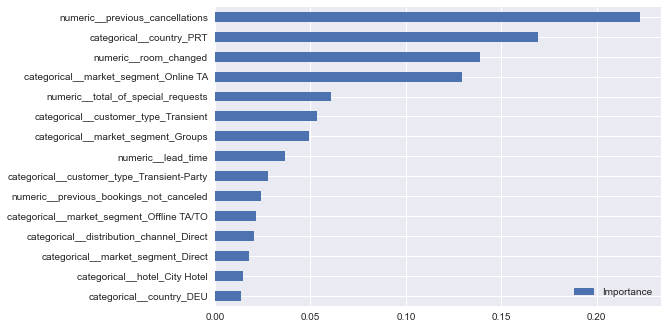

In [29]:
importances_df.sort_values('Importance', ascending=True).plot.barh()

The two clearly most important features are the number of previous cancellations and whether a customer is from Portugal. The remaining features all have a pretty low importance. Some features have importance close to 1%. For these, we might need to consider to remove them in order to improve model performance.

Next, we look at the performance of our model. For that, we define a set of standard evaluation functions we will reuse in the remainder of the notebook.

In [30]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix, roc_curve
import seaborn as sns

def get_cnf_matrix(y_true, y_pred, model_name: str = None):
    """
    This function receives a true y and a predicted y array. It plots a confusion matrix as sns.heatmap.

    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values.
        y_pred:
            numpy array or pandas Series / DF of predicted y values.
        model_name(str):
            Optional parameter to specify the name of the model in the title of the plot.
    """

    cnf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix

    class_names=[0,1]
    fig, ax = plt.subplots(figsize=(3.5,2.8), dpi=105)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix),
                annot=True,
                cmap="YlGnBu" ,
                fmt='g',
                )#annot_kws={"size": 15, "weight": "bold"})
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(f'Confusion Matrix {model_name if model_name is not None else ""}', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


def get_metrics(y_true, y_pred):
    """
    This function receives a true y and a predicted y array. It prints Recall, Precision and Accuracy.

    Parameters:
        y_true:
            numpy array or pandas Series / DF of true y values.
        y_pred:
            numpy array or pandas Series / DF of predicted y values.
    """
    print("Recall:", round(recall_score(y_true, y_pred),4))
    print("Precision:", round(precision_score(y_true, y_pred),4))
    print("Accuracy:", round(accuracy_score(y_true, y_pred),4))
    print("F1 Score:", round(f1_score(y_true, y_pred),4))


def get_roc_curve(y_true, pred_proba):
    y_pred_proba = pred_proba[::,1]
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba)

    #create ROC curve
    plt.figure(figsize=(4.3, 4), dpi=95)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linewidth=0.5, color='grey') # plot diagonal as reference line
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')

### 4.2 K-Means clustering of customers
When looking at which features are most important, it is striking that only few of the categorical features that depict the type of customer, such as the room in which they stay, the meal ordered, or the group size, are part of the top 15 features. Let's have a closer look at how these features ranked in the recursive feature elimination:

In [31]:
customer_attribs = ['guests', 'reserved_room_type', 'meal', 'stay_total_nights', 'is_family', 'hotel', 'distribution_channel', 'customer_type', 'is_repeated_guest']
feat_rank_names = feat_rank_df.index.tolist()
customer_attribs_mask = [any(customer_attrib in feat_name for customer_attrib in customer_attribs) for feat_name in feat_rank_names]
feat_rank_df[customer_attribs_mask]

,rank
categorical__distribution_channel_Direct,1
categorical__customer_type_Transient,1
categorical__hotel_City Hotel,1
categorical__customer_type_Transient-Party,1
categorical__distribution_channel_TA/TO,2
categorical__meal_Other,2
numeric__stay_total_nights,3
categorical__meal_SC,3
categorical__meal_HB,3
categorical__meal_BB,3


Only 4 of the customer characteristics made it into the top 15. The rest got eliminated pretty early. The reason for this could be that these features contain many sub-categories, so each sole subcategory does not explain cancellations sufficiently. There might still be the possibility that combined, these features actually *do* have relevance. In the following, we test this possibility by clustering customers based on their characteristics such as room type or meal and test, whether these clusters help to predict cancellations.

First, we binarize the categorical features:

In [32]:
cluster_df = df[customer_attribs]
cluster_df

,guests,reserved_room_type,meal,stay_total_nights,is_family,hotel,distribution_channel,customer_type,is_repeated_guest
0,2,C,BB,0,0,Resort Hotel,Direct,Transient,0
75559,1,A,HB,2,0,City Hotel,TA/TO,Transient,0
75560,2,A,HB,2,0,City Hotel,TA/TO,Transient,0
75561,2,A,HB,2,0,City Hotel,TA/TO,Transient,0
75562,2,A,HB,2,0,City Hotel,TA/TO,Transient,0
...,...,...,...,...,...,...,...,...,...
110887,2,A,BB,3,0,City Hotel,TA/TO,Transient,0
110763,1,G,BB,1,0,City Hotel,Direct,Transient,0
67265,1,A,SC,12,0,City Hotel,TA/TO,Transient,0
110878,2,A,BB,3,0,City Hotel,TA/TO,Transient,0


In [33]:
cols_to_binarize = cluster_df.columns[cluster_df.dtypes == 'object'].tolist()
for col in cols_to_binarize:
    dummy_cols = pd.get_dummies(cluster_df[col], prefix=col)
    cluster_df = pd.concat([cluster_df, dummy_cols], axis=1)
cluster_df.drop(columns=cols_to_binarize, axis=1, inplace=True)
cluster_df

,guests,stay_total_nights,is_family,is_repeated_guest,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,...,hotel_Resort Hotel,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,2,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
75559,1,2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
75560,2,2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
75561,2,2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
75562,2,2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110887,2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
110763,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
67265,1,12,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
110878,2,3,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


Next, we try different cluster sizes from 2 to 10 and observe the Silhouette Score (measures separation distance between clusters) and the Calinski-Harabasz Score (measures dispersion of clusters). For both scoring metrics, a higher value indicates better performance.

100%|██████████| 9/9 [23:44<00:00, 158.24s/it]


Text(0.5, 1.0, 'Silhouette and Calinski-Harabasz Scores for Variations of k')

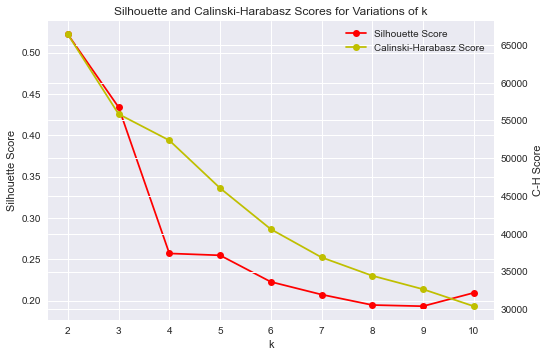

In [49]:
from sklearn.metrics import calinski_harabasz_score
from typing import List

sil_scores: List[float] = []
c_h_scores: List[float] = []
k_min = 2
k_max = 10
k_range = range(k_min, k_max+1)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=seed)
    kmeans.fit(cluster_df)
    labels = kmeans.labels_
    sil_score = silhouette_score(cluster_df, labels, metric = 'euclidean')
    c_h_score = calinski_harabasz_score(cluster_df, labels)
    sil_scores.append(sil_score)
    c_h_scores.append(c_h_score)

ax1 = plt.subplot()
l1, = ax1.plot(k_range, sil_scores, marker='o', color='r')
ax2 = ax1.twinx()
l2, = ax2.plot(k_range, c_h_scores, marker='o', color='y')
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax2.set_ylabel('C-H Score')
plt.legend([l1, l2], ["Silhouette Score", "Calinski-Harabasz Score"])
plt.title('Silhouette and Calinski-Harabasz Scores for Variations of k')

For both scores, we can try to find an "elbow" to determine the best k. For the silhouette score, this elbow can be located at k=4, while for the Calinski-Harabasz Score it is not very clear, though around k=6 or 7. To account for both separation and dispersion of clusters, we selected k=5 as a good value for k to capture the elbows of both scores.

In order to understand the resulting clusters better, we can look at their sizes and the 'median customer' of each:

In [34]:
kmeans = KMeans(n_clusters=5, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
pd.DataFrame(data=[pd.Series(kmeans.labels_).value_counts(), pd.Series(kmeans.labels_).value_counts(normalize=True)], index=['count', 'relative']).T

,count,relative
0,41809.0,0.430187
4,41791.0,0.430002
2,11121.0,0.114428
1,2229.0,0.022935
3,238.0,0.002449


More than 80% of the customers are clustered in the top 2 clusters. The remaining clusters are very small, especially cluster 2 and 4 with only 2.3% and 0.3% respectively. Looking at the insignificant size of cluster 4, we decided to reduce k from 5 to 4.

Let's have a look at how the median customer per cluster looks like for k=4:

In [35]:
kmeans = KMeans(n_clusters=4, n_init=30, max_iter=500, random_state=seed)
kmeans.fit(cluster_df)
cluster_df['predicted_cluster'] = kmeans.labels_
cluster_df.groupby('predicted_cluster').median()

,guests,stay_total_nights,is_family,is_repeated_guest,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,...,hotel_Resort Hotel,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
predicted_cluster,,,,,,,,,,,,,,,,,,,,,
0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [36]:
clusters = cluster_df['predicted_cluster'].unique()
for cluster in clusters:
    cluster_data = cluster_df[cluster_df['predicted_cluster'] == cluster]
    percent_of_total = cluster_data.shape[0] / cluster_df.shape[0]
    print(f"Cluster {cluster} ({round(percent_of_total*100, 2)}% of total):")
    for col in [c for c in cluster_data.columns if c != 'predicted_cluster']:
        count = cluster_data[col].value_counts(normalize=True)
        top_count = count.nlargest(1)
        print(f"\t{col}: {top_count.index[0]} ({int(round(top_count.values[0]*100,0))}%)")

Cluster 0 (43.02% of total):
	guests: 2 (63%)
	stay_total_nights: 2 (56%)
	is_family: 0 (95%)
	is_repeated_guest: 0 (94%)
	reserved_room_type_A: 1 (81%)
	reserved_room_type_B: 0 (99%)
	reserved_room_type_C: 0 (100%)
	reserved_room_type_D: 0 (90%)
	reserved_room_type_E: 0 (96%)
	reserved_room_type_F: 0 (98%)
	reserved_room_type_G: 0 (99%)
	reserved_room_type_H: 0 (100%)
	reserved_room_type_L: 0 (100%)
	reserved_room_type_P: 0 (100%)
	meal_BB: 1 (79%)
	meal_FB: 0 (99%)
	meal_HB: 0 (89%)
	meal_SC: 0 (91%)
	meal_Undefined: 0 (100%)
	hotel_City Hotel: 1 (70%)
	hotel_Resort Hotel: 0 (70%)
	distribution_channel_Corporate: 0 (90%)
	distribution_channel_Direct: 0 (85%)
	distribution_channel_GDS: 0 (100%)
	distribution_channel_TA/TO: 1 (75%)
	distribution_channel_Undefined: 0 (100%)
	customer_type_Contract: 0 (97%)
	customer_type_Group: 0 (99%)
	customer_type_Transient: 1 (71%)
	customer_type_Transient-Party: 0 (75%)
Cluster 3 (43.07% of total):
	guests: 2 (73%)
	stay_total_nights: 3 (52%)
	is_f

The clusters are not very clearly differentiated. In order to evaluate whether the resulting clusters will help to predict more accurately whether a customer cancels or not, we need to see if it improves the model performance. This will be done in 4.3 alongside variations of other features.

### 4.3 Feature Testing
#### 4.3.1 Standardized Feature Testing
First, we define a function that selects the data to be considered in the clusters. Second, we define a method that adopts the train and test set to incorporate only the features given as an argument. Third, we define a method that takes training and test sets, performs the XGBClassifier and outputs the results on the test set.

In [37]:
def make_cluster_df(cust_cluster_attribs_num, cust_cluster_attribs_bin, cust_cluster_attribs_cat):
    cluster_numeric_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )

    cluster_binary_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median'))
        ]
    )

    cluster_categorical_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ]
    )

    clustering_preprocessing = ColumnTransformer(
        transformers=[
            ('num', cluster_numeric_transformer, cust_cluster_attribs_num),
            ('cat', cluster_categorical_transformer, cust_cluster_attribs_cat),
            ('binary', cluster_binary_transformer, cust_cluster_attribs_bin)
        ]
    )

    clustering_pipeline = Pipeline(
        steps=[
            ('preprocessor', clustering_preprocessing),
            ('kmeans', KMeans(n_clusters=4, n_init=20, max_iter=500, random_state=seed))
        ]
    )

    clustering_pipeline.fit(df)
    df_cluster_performance_train = feature_selection_df.copy()
    df_cluster_performance_test = feature_selection_test_df.copy()
    df_cluster_performance_train['customer_cluster'] = clustering_pipeline.named_steps['kmeans'].labels_
    df_cluster_performance_test['customer_cluster'] = clustering_pipeline.predict(df_test)

    return df_cluster_performance_train, df_cluster_performance_test

In [38]:
def select_features(X_clustered_train, X_clustered_test, features: list, cluster_yes: bool):
    if cluster_yes:
        features.append('customer_cluster')
    X_clustered_train = X_clustered_train[features]
    X_clustered_test = X_clustered_test[features]
    if cluster_yes:
        cluster_dummies_train = pd.get_dummies(X_clustered_train['customer_cluster'], prefix="customer_cluster")
        cluster_dummies_test = pd.get_dummies(X_clustered_test['customer_cluster'], prefix="customer_cluster")
        X_clustered_train = pd.concat([X_clustered_train, cluster_dummies_train], axis=1).drop(columns=['customer_cluster'])
        X_clustered_test = pd.concat([X_clustered_test, cluster_dummies_test], axis=1).drop(columns=['customer_cluster'])
    return X_clustered_train, X_clustered_test

In [39]:
def evalute_xgb(X_train, y_train, X_test, y_test):

    xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
    xgb.fit(X_train, y_train)

    # Printing the metrics
    y_pred = xgb.predict(X_test)
    y_pred_proba = xgb.predict_proba(X_test)
    get_metrics(y_test, y_pred)
    get_cnf_matrix(y_test, y_pred)
    get_roc_curve(y_test, y_pred_proba)

    return xgb

In [22]:
def compare_xgb(model_1, model_2, X_test_1, X_test_2, y_true, model_1_name='Base', model_2_name='Enhanced'):
    metrics_df = pd.DataFrame(index=["F1-Score", "Accuracy", "Recall", "Precision"])
    models_iterator = zip([model_1, model_2], [X_test_1, X_test_2], [model_1_name, model_2_name])
    for model_variant in models_iterator:
        model, X_test, model_name = model_variant
        y_pred = model.predict(X_test)

        # get metrics
        f1 = f1_score(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        metrics = [round(metric, 4) for metric in [f1, accuracy, recall, precision]]
        model_metrics = pd.Series(name=model_name, data=metrics, index=["F1-Score", "Accuracy", "Recall", "Precision"])
        metrics_df = pd.concat([metrics_df, model_metrics], axis=1)
    metrics_df['Change'] = metrics_df.apply(lambda r: f'{"+" if (r[model_2_name] - r[model_1_name]) >= 0 else ""}{str(round(r[model_2_name] - r[model_1_name], 4))}', axis=1)

    print(metrics_df)
    get_roc_curve_multiple([model_1, model_2], [X_test_1, X_test_2], y_true, [model_1_name, model_2_name])
    for model_variant in zip([model_1, model_2], [X_test_1, X_test_2], [model_1_name, model_2_name]):
        model, X_test, model_name = model_variant
        y_pred = model.predict(X_test)
        get_cnf_matrix(y_true, y_pred, model_name)

#### 4.3.3 Do more or less features improve the performance?
Using 15 as number of features in the preliminary model selection was an educated guess on a suitable amount of features. In the following we will see whether this number is actually optimal. We will check the average training F1 score of 5-fold cross-validation for number of features ranging from 5 to 40. In addition to the features used in the preliminary model selection, we also use the customer clusters as categorical features.

In [41]:
n_feat_min = 5
n_feat_max = 40
n_feature_range = range(n_feat_min, n_feat_max+1)
f1_scores: List[float] = []

adv_feature_selection_df, _ = select_features(feature_selection_df.copy(), feature_selection_test_df.copy(), feature_selection_df.columns.tolist(), cluster_yes = False)

xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
rfe = RFE(xgb, n_features_to_select=n_feat_min, step=1)
rfe.fit(adv_feature_selection_df, df['is_canceled'])
feat_rank_df = pd.DataFrame(data=rfe.ranking_,
                            index=adv_feature_selection_df.columns,
                            columns=['rank']).sort_values('rank', ascending=True)

Text(0.5, 1.0, 'F1-Score for variations of number of features')

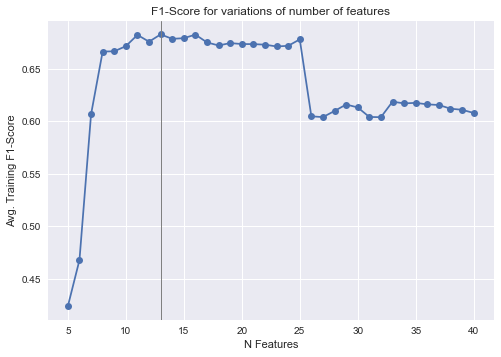

In [42]:
for n_feat in n_feature_range:
    features_list = feat_rank_df[feat_rank_df['rank'] <= (n_feat - n_feat_min + 1)].index.tolist()

    xgb_feat = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
    scores = cross_val_score(xgb_feat, adv_feature_selection_df[features_list], df['is_canceled'], scoring="f1", cv=splitter, n_jobs=-1)
    f1 = scores.mean()
    f1_scores.append(f1)
plt.plot(n_feature_range, f1_scores, marker='o')
plt.axvline(n_feature_range[np.argmax(f1_scores)], c='grey', lw=1)
plt.xlabel('N Features')
plt.ylabel('Avg. Training F1-Score')
plt.title('F1-Score for variations of number of features')

In [50]:
print(f"Number of features highest score: {n_feature_range[np.argmax(f1_scores)]}")
print(f"Score improvement: {round(np.max(f1_scores) - preliminary_comparison_df.loc['XGBoost Classifier', 'Avg. Train F1'], 4)}")

Number of features highest score: 13
Score improvement: 0.0066


The highest training F1 Score was achieved using **13 features**. This is quite close to our initial guess of 15, to which we were able to improve the f1-score by 0.0066.

The average training score plotted against the features shows, that there are many numbers of features, that achieve similar performance to the maximum of 13 features. This number of features with very good performance ranges from 12-25 features. However, 13 features is likely to be a good choice, as a simpler model, with less features, should be chosen over a more complex model.

In [40]:
top_remain_features = feat_rank_df[:13].index.tolist()
top_remain_features

['categorical__market_segment_Online TA',
 'categorical__market_segment_Groups',
 'categorical__country_PRT',
 'numeric__room_changed',
 'numeric__previous_cancellations',
 'categorical__customer_type_Transient',
 'numeric__total_of_special_requests',
 'numeric__lead_time',
 'categorical__customer_type_Transient-Party',
 'categorical__distribution_channel_Direct',
 'numeric__previous_bookings_not_canceled',
 'categorical__market_segment_Offline TA/TO',
 'categorical__customer_type_Other']

The included features don't belong to those features that have strong colinearity (identified in *2. EDA*) and all display unique information. Therfore, we 'trust' the model that this set of features offers little to no potential improvement.

In a next step we want to analyze whether using clusters of customer features can help to improve model performance. Some of the customer features like 'customer_type' are already included in the feature list. They will be not included in the cluster features. The following features are not included, therefore they will be used to build clusters. 

In [ ]:
features_for_clusters = ['guests', 'reserved_room_type', 'meal', 'stay_total_nights', 'is_family', 'hotel', 'is_repeated_guest']

#### 4.3.2 Do the clusters improve model performance?
We will build to models to evaluate the performance with and without features. 

In a first run we use the Top 13 features with the highest feature importance for the XGB Classifier.
In a second run we will add the previously proposed features for building the clusters.

We will evaluate both runs with the following functions that cross validates the model on our TimeSeriesSplit and return the f1 score.

In [51]:
def cross_val_xgb(X_train):
    xgb_feat = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')
    scores = cross_val_score(xgb_feat, X_train, df['is_canceled'], scoring="f1", cv=splitter, n_jobs=-1)
    f1 = scores.mean()
    return f1

In [52]:
top_remain_features = feat_rank_df[:13].index.tolist()

# Creating X_train without clusters
X_train_base, _ = select_features(feature_selection_df.copy(), feature_selection_test_df.copy(), top_remain_features, cluster_yes = False)

# Creating X_train with clusters
cust_cluster_attribs_num = ['guests', 'stay_total_nights']
cust_cluster_attribs_bin = ['is_family', 'is_repeated_guest']
cust_cluster_attribs_cat = ['reserved_room_type', 'meal', 'hotel']

X_clustered_train, X_clustered_test = make_cluster_df(cust_cluster_attribs_num, cust_cluster_attribs_bin, cust_cluster_attribs_cat)
X_train_cluster, _ = select_features(X_clustered_train, X_clustered_test, top_remain_features, cluster_yes = True)

f1_scores = {"F1_without_clusters" : round(cross_val_xgb(X_train_base),4),
                          "F1_with_clusters" : round(cross_val_xgb(X_train_cluster),4)}

In [53]:
print(f1_scores)
print(round(f1_scores['F1_with_clusters']-f1_scores['F1_without_clusters'],4))

{'F1_without_clusters': 0.6829, 'F1_with_clusters': 0.6728}
-0.0101


As the clusters reduce the F1 Score by 0.0101 we will not include them in our final feature set. As we want to choose a simpler model over a more complex one and the performance is reduced, this decision is straightforward.

Therefore we will move forward to hyperparameter tuning with the 13 features previously identified.

Lets see how the feature importance changed when reducing to 13 features 

### 4.4 Hyperparameter Tuning

We will use the previously defined methods to obtain the optimal combinations of features and clusters in X_train and X_test.

In [54]:
top_remain_features = feat_rank_df[:13].index.tolist()
X_train, X_test = select_features(X_clustered_train, X_clustered_test, top_remain_features, cluster_yes = False)

print(X_train.shape, X_test.shape)

(97188, 13) (22198, 13)


Now as we have our final X_train and X_test ready, we will start the hyperparameter tuning. 

The hyperparameter ranges tested, were obtained through desk research as good combination of parameters for problem. The optimal parameters are used according to the highest f1-score (as discussed previously).

In [55]:
xgb = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', objective = 'binary:logistic')

params = {
    "learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],  # 0.01-0.3 (learningrate)
    "min_child_weight" : [0.5, 1, 2], 
    "max_depth" : [3, 6, 10],  # 3-10 6 is default use cv
    "min_split_loss" :[0, 10, 100, 1000],  # 0 is default 
    "subsample" : [0.5, 0.75, 1],  # 0.5-1  1 is default
    "reg_lambda" : [1, 2, 5],  # regularization term
    "scale_pos_weight" : [1, 2, 5, 10],  # Use a value greater then one in case of imbalance
}

search = RandomizedSearchCV(xgb,
                            params,
                            n_jobs =- 1,
                            n_iter = 100,
                            random_state= seed,
                            scoring = 'f1',
                            verbose = 2,
                            cv = splitter
                            )
search.fit(X_train, df['is_canceled'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=15000),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importanc...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100, n_jobs=-1,
                   par

In [56]:
results_df = pd.DataFrame(search.cv_results_).sort_values(by = 'rank_test_score')
display(results_df.head(5))
print("Optimal cross validation score: " + str(round(results_df['mean_test_score'].iloc[0],4)))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_min_split_loss,param_min_child_weight,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
32,21.379907,9.104235,0.108398,0.013602,0.75,2,5,100,2,6,0.1,"{'subsample': 0.75, 'scale_pos_weight': 2, 're...",0.660165,0.815009,0.773220,0.714563,0.727089,0.738009,0.052721,1
99,10.368200,3.942861,0.103599,0.028147,0.75,2,2,100,2,3,0.1,"{'subsample': 0.75, 'scale_pos_weight': 2, 're...",0.663928,0.811412,0.769450,0.714120,0.727423,0.737267,0.050089,2
17,46.057079,17.754239,0.167801,0.085336,0.75,2,2,100,1,10,0.1,"{'subsample': 0.75, 'scale_pos_weight': 2, 're...",0.662425,0.803753,0.773960,0.715800,0.729620,0.737112,0.048759,3
75,10.888399,4.103495,0.095801,0.010246,0.75,2,5,10,0.5,3,0.1,"{'subsample': 0.75, 'scale_pos_weight': 2, 're...",0.652819,0.813496,0.769134,0.718092,0.729232,0.736555,0.053642,4
92,10.722514,4.114882,0.101000,0.013400,0.75,2,2,10,0.5,3,0.1,"{'subsample': 0.75, 'scale_pos_weight': 2, 're...",0.653400,0.810917,0.770987,0.717578,0.729548,0.736486,0.052989,5


Optimal cross validation score: 0.738


Great, hyperparamter tuning as improved the f1 score by 0.05 on the cross validated training set.

Lets use the best estimator from the randomized search and see how it performs on the test set.

But first lets take a look hoe feature reduction an hyperparameter tuning impacted the feature importances:

In [ ]:
model = XGBClassifier(subsample=0.75,scale_pos_weight=2,
                                     reg_lambda=5,
                                     min_split_loss=100,
                                     min_child_weight=2,
                                     max_depth=6,
                                     learning_rate=0.1)

xgb_feature_imp = model.fit(X_train, df['is_canceled'])

importances_df_2 = pd.DataFrame(data=xgb_feature_imp.feature_importances_, index=remaining_features, columns=['Importance']).sort_values('Importance', ascending=False)
importances_df_2

In [ ]:
explainer = shap.TreeExplainer(xgb_feature_imp)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.summary_plot(shap_values, X_test)

After reducing the features from 15 to 13 the ranking of feature importances has changed. In comparison to the 15 features, we see that the country orgin has become the most importnant as also the magnetudes of inpack on the model have changed. 

### 4.5 Tuning Summary
After optimzing the features and hyperparamters we use for our XGBosst Classifier, we can have a look at how our final model performs and at how much we have improved through the tuning process:

In [71]:
tuning_comparison = pd.DataFrame(columns=['Before Tuning', 'After Tuning'])
tuning_comparison.loc['Avg. Train F1-Score'] = [preliminary_comparison_df.loc['XGBoost Classifier', 'Avg. Train F1'] ,round(results_df['mean_test_score'].iloc[0],4)]
tuning_comparison.loc['Test F1-Score'] = [preliminary_comparison_df.loc['XGBoost Classifier', 'Test F1'], round(f1_score(df_test['is_canceled'], search.best_estimator_.predict(X_test)), 4)]
change = tuning_comparison['After Tuning'] - tuning_comparison['Before Tuning']
tuning_comparison['Change'] = change.apply(lambda x: "+" + str(round(x, 4) if x > 0 else str(round(x, 4))))
tuning_comparison

,Before Tuning,After Tuning,Change
Avg. Train F1-Score,0.6763,0.738,+0.0617
Test F1-Score,0.6808,0.712,+0.0312


Very nice! We could increase both train and test score. Now, the train score is higher than the test score which indicates some overfitting. Nevertheless, the difference is small so the overfitting happens in an acceptable magnitude.

Next, let's see how exactly our model performs on the test set:

Recall: 0.7064
Precision: 0.7178
Accuracy: 0.7683
F1 Score: 0.712


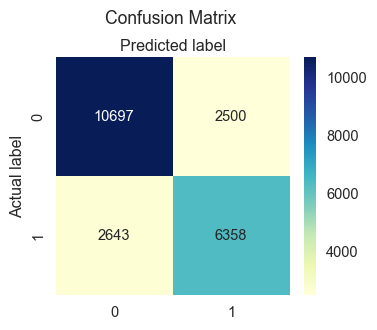

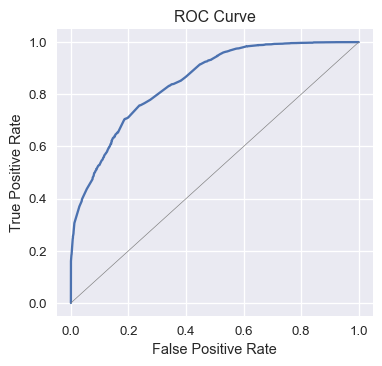

In [57]:
best_est_hparam = search.best_estimator_

y_pred_hparam = best_est_hparam.predict(X_test)
y_pred_proba_hparam = best_est_hparam.predict_proba(X_test)
get_metrics(df_test['is_canceled'], y_pred_hparam)
get_cnf_matrix(df_test['is_canceled'], y_pred_hparam)
get_roc_curve(df_test['is_canceled'], y_pred_proba_hparam)

As the high performance metric scores imply, the vast majority of predictions is correct.
False positives (FPs) and false negatives (FNs) are very well balanced. This is good for our business case, since FPs and FNs neutralize each other, i.e. the correct total number of guests to arrive is correct and thus no overbooking or underutlization occurs.

The ROC curves indicates good performance as well as it is well balanced towards the top left.

We can see that the model tuning has lead to improved performance and an overall good model. Based on this, we will build our model on the following features and hyperparameters, resulting from the model tuning:

In [58]:
top_remain_features

['categorical__market_segment_Online TA',
 'categorical__market_segment_Groups',
 'categorical__country_PRT',
 'numeric__room_changed',
 'numeric__previous_cancellations',
 'categorical__customer_type_Transient',
 'numeric__total_of_special_requests',
 'numeric__lead_time',
 'categorical__customer_type_Transient-Party',
 'categorical__distribution_channel_Direct',
 'numeric__previous_bookings_not_canceled',
 'categorical__market_segment_Offline TA/TO',
 'categorical__customer_type_Other']

In [59]:
search.best_params_

{'subsample': 0.75,
 'scale_pos_weight': 2,
 'reg_lambda': 5,
 'min_split_loss': 100,
 'min_child_weight': 2,
 'max_depth': 6,
 'learning_rate': 0.1}

## 5. Final Pipeline
Now that we have determined the best model & its hyperparameters as well as the best set of features to feed into it, it'S time to construct the final pipeline with which we can put the model into production.

In [11]:
#Define categories of attributes
num_attribs = ["lead_time", "previous_cancellations", "total_of_special_requests"]
num_attribs_bin = ["room_changed", "previous_bookings_not_canceled"]
cat_attribs_bin: Dict[str, str] = [
    # (column, true value)
    ("country", "PRT"),
    ("market_segment", "Online TA"),
    ("market_segment", "Groups"),
    ("market_segment", "Offline TA/TO"),
    ("customer_type", "Transient"),
    ("customer_type", "Transient-Party"),
    ("distribution_channel", "Direct")
]
cat_attribs_group: Dict[str, list] = [
    # (column, group values)
    ("customer_type", ["Contract", "Group"])
]

# Create a class to select specified columns from DataFrame
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X) -> np.ndarray:
        return X[self.attribute_names].values


def binary_tansformer_cat(arr: np.ndarray, true_vals: List[str]) -> np.ndarray:
    """
    Function for one-vs-all binary transformation of categorical values. 
    The purpose is to avoid one hot encoding of entire column if only one or a few one-vs-all features are needed.
    
    Args:
        arr (numpy.ndarray): Matrix of raw column values. For each of the true values to compare against, one column with matching index must be provided.
        true_vals (list[str]): List of true values to compare each column against. The index of the true value in the list must match the index of the column in matrix 'arr'.
    
    Returns:
        numpy.ndarray: Matrix of same size as 'arr', with each column binarized with respect to the true value specified in 'true_vals'.
    """
    for i, true_val in enumerate(true_vals):
        arr[:, i] = np.where(arr[:, i] == true_val, 1, 0)
    return arr


def group_transformer_cat(arr, true_val_groups: List[List[str]]) -> np.ndarray:
    """
    Function to binarize columns with regard to whether a value is in a list of true values. 
    This is needed as we group some values of categorical features into the category 'other' if their relative occurence is <5%.
    
    Args:
        arr (numpy.ndarray): Matrix of raw column values. For each of the lists of true values to compare against, one column with matching index must be provided.
        true_val_groups (list[list[str]]): List of lists of true values to compare each column against. The index of the list of true values in the list must match the index of the column in matrix 'arr'.
    
    Returns:
        numpy.ndarray: Matrix of same size as 'arr', with each column binarized with respect to the list of true values specified in 'true_val_groups'.
    """
    for i, true_val_group in enumerate(true_val_groups):
        arr[:, i] = np.where(np.isin(arr[:, i], true_val_group), 1, 0)
    return arr


num_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="mean")),
        ('scaler', StandardScaler())
    ])

num_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector(num_attribs_bin)),
        ('imputer', SimpleImputer(strategy="median")),
        ('binarizer', Binarizer())
    ])

cat_binary_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector([e[0] for e in cat_attribs_bin])),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('binarizer_cat', FunctionTransformer(binary_tansformer_cat, kw_args={'true_vals': [e[1] for e in cat_attribs_bin]}))
    ])

cat_group_pipeline = Pipeline(
    steps=[
        ('selector', ColumnSelector([e[0] for e in cat_attribs_group])),
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('grouper_cat', FunctionTransformer(group_transformer_cat, kw_args={'true_val_groups': [e[1] for e in cat_attribs_group]}))
    ]
)

preprocessor = FeatureUnion(
    transformer_list = [
        ('num_pipeline', num_pipeline),
        ("num_binary_pipeline", num_binary_pipeline),
        ("cat_binary_pipeline", cat_binary_pipeline),
        ("cat_group_pipeline", cat_group_pipeline),
    ])

booking_cancellation_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(subsample=0.75,
                                     scale_pos_weight=2,
                                     reg_lambda=5,
                                     min_split_loss=100,
                                     min_child_weight=2,
                                     max_depth=6,
                                     learning_rate=0.1))
    ]
)

In [12]:
set_config(display="diagram")
booking_cancellation_model

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('num_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(attribute_names=['lead_time',
                                                                                                  'previous_cancellations',
                                                                                                  'total_of_special_requests'])),
                                                                 ('imputer',
                                                                  SimpleImputer()),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('num_binary_pipeline',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(attribute_names=['...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=2,
                               min_split_loss=100, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, ...))])

In [13]:
booking_cancellation_model.fit(df, df['is_canceled'])
pred = booking_cancellation_model.predict(df_test)
f1_score(df_test['is_canceled'], pred)

0.7118073100892708

## <a id='businesscase'>6. Business Case Calculation</a>

To check how our model can benefit the hotel, we will do a business case that will calculate how much additional revenue a hotel can earn using our prediction mechanism. We will compare two models: Firstly, our model where we predict the cancellation on a per-room basis and aggregate the additional revenue per day. Secondly, the traditional prediction tool used by hotels that is based on the cancellation rate of the previous year. Let's start with our model.

### 6.1 Room-based overbooking (our model)

To calculate this business case, we will make a set of assumptions:
- There are two scenarios that affect revenue: Firstly, we correctly predict the cancellation of a room, which will give the hotel additional income. Secondly, we have overbooked too many rooms for the night (i.e., there are more false positives than false negatives, more information [here](#performancemeasure)), which will lead to a loss of revenue.
- In case we correctly predict a room that has been cancelled (True Positive), we will count that revenue as additional revenue we gained through our model. Because this revenue would usually be lost out on and through the model's prediction and correct overbooking, the hotel is able to fill the room. We will calculate this additional revenue as the revenue of the cancelled stay times a factor of 0.8, as we cannot be sure that the room can actually be filled.
- In case we have more false positives than false negatives, i.e. we have overbooked to many rooms and there are customers that cannot be served, we will count this as a loss of revenue through our model, as the hotel will have to find rooms for the overbooked guests on short notice and the hotel's reputation will be negatively affected. As we will still gain the revenue of the customer, but have to find a new hotel (often more expensive) and suffer a loss of reputation, we have set this factor at 0.5 of the median revenue per stay.
- The hotel is fully booked in the timeframe of our business case and overbooking therefore means selling rooms above the hotel's capacity.

Let's first have a look at our model's predictions:

In [14]:
df_businesscase = df_test
booking_cancellation_model.fit(df, df['is_canceled'])
df_businesscase['stay_total_revenue'] = df_businesscase['stay_total_nights'] * df_businesscase['adr']
df_businesscase['is_canceled_predicted'] = booking_cancellation_model.predict(df_businesscase)
df_businesscase.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,arrival_date,booking_date,booking_date_day_of_week,guests,stay_total_nights,is_family,room_changed,adr_per_guest,stay_total_revenue,is_canceled_predicted
67324,City Hotel,1,157,2017,5,18,1,1,3,2,...,2017-05-01,2016-11-25,4,2,4,0,0,65.0,520.0,1
110964,City Hotel,0,13,2017,5,18,1,1,3,2,...,2017-05-01,2017-04-18,1,2,4,0,0,56.0,448.0,0
110963,City Hotel,0,17,2017,5,18,1,1,3,2,...,2017-05-01,2017-04-14,4,2,4,0,0,70.0,560.0,0
67320,City Hotel,1,61,2017,5,18,1,1,3,2,...,2017-05-01,2017-03-01,2,2,4,0,0,93.6,748.8,0
23425,Resort Hotel,0,1,2017,5,18,1,1,2,2,...,2017-05-01,2017-04-30,6,2,3,0,0,63.5,381.0,0


In [15]:
#Get revenue values (with and w/o cancelations)
print("Revenue without cancellations: ", df_businesscase.stay_total_revenue.sum())
print("Revenue with cancellations: ", df_businesscase[df_businesscase['is_canceled'] == 0].stay_total_revenue.sum())

Revenue without cancellations:  11534874.33
Revenue with cancellations:  6547646.38


During the focal period (May until August 2017), the the hotel would have made a total revenue of roughly €11.6M if no customer had cancelled their booking. Factoring in the cancellations, the hotel would end up with a total revenue of roughly €6.6M. **Our model can help close this gap** and give the hotel the opportunity to precisely overbook and therefore fill the calcelled rooms.

In [16]:
df_profit = df_businesscase[['is_canceled', 'is_canceled_predicted', 'arrival_date', 'adr', 'stay_total_revenue']]
df_profit['correctly_classified'] = np.where((df_profit['is_canceled'] == df_profit['is_canceled_predicted']),
                                             1,
                                             0)
df_profit['additional_revenue'] = np.where((df_profit['is_canceled'] == 1) & (df_profit['correctly_classified'] == 1), 
                                       df_profit['stay_total_revenue'],
                                       0) * 0.8

median_total_revenue = df_profit.stay_total_revenue.mean()

df_profit_agg = df_profit.groupby('arrival_date').sum()

df_profit_agg['overbooked_rooms'] = df_profit_agg['is_canceled_predicted'] - df_profit_agg['is_canceled']
df_profit_agg['overbooked_rooms'] = np.where(df_profit_agg['overbooked_rooms'] < 0, 
                                                0, 
                                                df_profit_agg['overbooked_rooms'])
df_profit_agg['neg_adr_overbooking'] = df_profit_agg['overbooked_rooms'] * median_total_revenue * 0.5

df_profit_agg.head()

,is_canceled,is_canceled_predicted,adr,stay_total_revenue,correctly_classified,additional_revenue,overbooked_rooms,neg_adr_overbooking
arrival_date,,,,,,,,
2017-05-01,88,76,24705.02,97718.79,169,27393.792,0,0.0
2017-05-02,42,34,18984.56,68791.36,140,9139.360,0,0.0
2017-05-03,121,100,23846.71,75939.27,168,30329.200,0,0.0
2017-05-04,154,143,29002.40,86097.22,219,32547.840,0,0.0
2017-05-05,125,113,30637.12,92443.19,198,25458.784,0,0.0


In [23]:
print("Additional Revenue: ", round(df_profit_agg.additional_revenue.sum() - df_profit_agg.neg_adr_overbooking.sum(),2))

Additional Revenue:  2607632.59


Based on our assumptions and using our predictions, we are able to earn an **additional €2.61M of revenue for the hotel** compared to the base line of no overbooking.

### 6.2 Overbooking based on previous cancellation rates (traditional model)

Traditionally, hotels have used a very simple, yet effective, prediction model to overbook the rooms of their hotels. Hotels use the calcelation rate of the same month a year back and apply it to the number of rooms booked for the current timeframe. For example, if the last year's average monthly cancellation rate was 30% and the hotel has 100 bookings on the same day this year, they will overbook 30 rooms to make up for cancellations. As this is a very rough and unflexible estimate, we hypothesize, that this model will yield lower additional revenue.

The same assumptions as for the model in 6.2 apply here.

Let's calculate the average monthly cancelation rate of the previous years:

In [18]:
start_date = datetime.datetime(2016, 5, 1)
end_date = datetime.datetime(2016, 8, 31)
df_cancelationrate = df[(df['arrival_date'] >= start_date) & (df['arrival_date'] <= end_date)]
df_cancelationrate = df_cancelationrate[['is_canceled','arrival_date_month']]
df_cancelationrate_agg = df_cancelationrate.groupby('arrival_date_month')['is_canceled'].agg(['sum', 'count', 'mean']) 
df_cancelationrate_agg.columns = ['is_canceled', 'total_bookings', 'cancelation_rate']
df_cancelationrate_agg

,is_canceled,total_bookings,cancelation_rate
arrival_date_month,,,
5,1915,5478,0.349580
6,2096,5292,0.396070
7,1499,4572,0.327865
8,1825,5063,0.360458


In [19]:
df_traditional = df_test
df_traditional_agg = df_traditional.groupby('arrival_date')['is_canceled'].agg(['sum', 'count']).reset_index()
df_traditional_agg.columns = ['arrival_date', 'is_canceled', 'total_bookings']

#Create cancelationrate column
start_jun = datetime.datetime(2017, 6, 1)
start_jul = datetime.datetime(2017, 7, 1)
start_aug = datetime.datetime(2017, 8, 1)

conditions = [
    (df_traditional_agg['arrival_date'] < start_jun),
    (df_traditional_agg['arrival_date'] >= start_jun) & (df_traditional_agg['arrival_date'] < start_jul),
    (df_traditional_agg['arrival_date'] >= start_jul) & (df_traditional_agg['arrival_date'] < start_aug),
    (df_traditional_agg['arrival_date'] >= start_aug)
    ]

values = [df_cancelationrate_agg.iloc[0, 2], 
          df_cancelationrate_agg.iloc[1, 2], 
          df_cancelationrate_agg.iloc[2, 2], 
          df_cancelationrate_agg.iloc[3, 2]]

df_traditional_agg['last_year_cancelation_rate'] = np.select(conditions, values)

#Create predicted cancelations
df_traditional_agg['is_canceled_predicted'] = round(df_traditional_agg['total_bookings'] * df_traditional_agg['last_year_cancelation_rate']).astype('int')

#Get average revenues and adr per booking
median_total_revenue = df_profit.stay_total_revenue.median()

#Calculate overbooked rooms
df_traditional_agg['overbooked_rooms'] = df_traditional_agg['is_canceled_predicted'] - df_traditional_agg['is_canceled']
df_traditional_agg['overbooked_rooms'] = np.where(df_traditional_agg['overbooked_rooms'] < 0,
                                                  0,
                                                  df_traditional_agg['overbooked_rooms'])

df_traditional_agg['additional_revenue'] = (df_traditional_agg['is_canceled_predicted'] - df_traditional_agg['overbooked_rooms']) * median_total_revenue * 0.8
df_traditional_agg['neg_adr_overbooking'] = df_traditional_agg['overbooked_rooms'] * median_total_revenue * 0.5
df_traditional_agg.head()

,arrival_date,is_canceled,total_bookings,last_year_cancelation_rate,is_canceled_predicted,overbooked_rooms,additional_revenue,neg_adr_overbooking
0,2017-05-01,88,205,0.34958,72,0,22876.128,0.0000
1,2017-05-02,42,174,0.34958,61,19,13344.408,3772.9725
2,2017-05-03,121,213,0.34958,74,0,23511.576,0.0000
3,2017-05-04,154,262,0.34958,92,0,29230.608,0.0000
4,2017-05-05,125,260,0.34958,91,0,28912.884,0.0000


In [22]:
print("Additional Revenue: ", round(df_traditional_agg.additional_revenue.sum() - df_traditional_agg.neg_adr_overbooking.sum(),2))

Additional Revenue:  2369863.6


The traditional model of overbooking based on previous cancellation rates yields an additional revenue of **€2.37M through overbooking, €240k less than our model across the four months**. This is confirming our hypothesis, that the traditional approach will lead to a lower result than our machine learning model.